# Multivariate Gaussian HMM on example session

In [1]:
""" 
IMPORTS
"""
import os
import autograd.numpy as np
import pickle
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import seaborn as sns
from collections import defaultdict
import pandas as pd

from one.api import ONE
from jax import vmap
from pprint import pprint
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
from dynamax.hidden_markov_model import GaussianHMM

# Get my functions
functions_path =  '/home/ines/repositories/representation_learning_variability/Models/Sub-trial//2_fit_models/'
#functions_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability//Models/Sub-trial//2_fit_models/'
os.chdir(functions_path)
from fitting_functions import plot_transition_matrix, cross_validate_model
from plotting_functions import plot_states_aligned

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


### Get design matrix

Get session data for corresponding session (only one available for now)

In [2]:
# Parameters
bin_size = 0.1

one = ONE()

data_path =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/' + str(bin_size) + '/'
os.chdir(data_path)
design_matrices = os.listdir(data_path)

1. Preprocess design matrix(s) with different time resolution

In [11]:
# Save data of all sessions for latter
matrix_all = defaultdict(list)
session_all = defaultdict(list)
test_all = defaultdict(list)

for m, mat in enumerate(design_matrices):
   
    # Trials data
    session = design_matrices[m][14:-4]
    session_trials = one.load_object(session, obj='trials', namespace='ibl')
    session_trials = session_trials.to_df()
    session_length = list(session_trials['stimOff_times'][-1:])[0]  # TODO: this might not work if stimOff times are missing

    big_design_matrix = pickle.load(open(mat, "rb"))
    var_names = ['avg_wheel_vel', 'pupil_diameter',
       'whisker_me', 'nose_speed_X', 'nose_speed_Y', 
       'l_paw_speed_X', 'l_paw_speed_Y', 'pupil_speed_X',
       'pupil_speed_Y', 'Gaussian_licks']
    
    design_matrix = big_design_matrix.groupby('Bin')[var_names].mean()  # 
    design_matrix = design_matrix.reset_index(level=[0])  # , 'Onset times'
    design_matrix = design_matrix.dropna()
    
    # Trim design matrix to be as long as the session (otherwise it will include task-unrelated behavior)
    design_matrix = design_matrix.loc[design_matrix['Bin']<session_length*10]

    # Keep some fraction of the data for the test set and don't touch it!
    inpt = np.array(design_matrix[var_names]).copy() 
    split_parts = 5
    length = len(inpt)// split_parts * split_parts
    training_length = int(length - (length/5))
    test_length = int(length/5)
    
    # Leave test set as the middle 5th part (to avoid effects of early/late session)
    training_set = jnp.concatenate([inpt[:test_length*2], inpt[-test_length*2:]])
    test_set = inpt[test_length*2:test_length*3]
    
    # Standardization using StandardScaler
    #scaler = StandardScaler()
    #standardized_matrix = scaler.fit_transform(inpt)

    # Save results
    
    matrix_all[mat].append(training_set)
    session_all[mat].append(session_trials)
    test_all[mat].append(test_set)
    

2. Preprocess design matrix constructed from PCs

In [19]:
data_path =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/'
os.chdir(data_path)

datasets = ["design_matrix_dim_reduc_0.1"]

matrix_all_bins = defaultdict(list)

for b, binning in enumerate(datasets):
    big_design_matrix = pickle.load(open(binning, "rb"))

    design_matrix = big_design_matrix.dropna()

    # Move 
    inpt = np.array(design_matrix[['pc1', 'pc2', 'pc3', 'pc4']]).copy() # keep only first 4 PC (based on variance explained plot (see dimensionality_reduction.ipynb))
    split_parts = 5
    length = len(inpt)// split_parts * split_parts
    training_length = int(length - (length/5))
    training_set = inpt[:training_length, :]
    
    # Standardization using StandardScaler
    #scaler = StandardScaler()
    #standardized_matrix = scaler.fit_transform(inpt)

    standardized_matrix = training_set

    # Save design matrix    
    matrix_all_bins[binning].append(training_set)

## Parameters

In [4]:
num_iters = 100
num_train_batches = 5
last_state = 5  # Test up until last_state Ks
state_step = 1

## Cross-validate and compare models with different K and different time resolutions

In [114]:
binning_lengths = [0.03, 0.05, 0.1]
binning_lengths = [0.1]
for c, binning in enumerate(binning_lengths):
    
    print('Fitting models with ' + str(binning) + ' time resolution')
    # Shorten array so that equal division is possible
    standardized_matrix = matrix_all_bins['design_matrix_v2_' + str(example_session) + '_' + str(binning)]
    #standardized_matrix = matrix_all_bins['design_matrix_v2_' + str(binning)]

    emission_dim = np.shape(standardized_matrix[0])[1]
    num_timesteps = np.shape(standardized_matrix[0])[0]
    
    shortened_array = standardized_matrix[0][:num_timesteps // num_train_batches * num_train_batches]
    # Split data into folds
    train_emissions = jnp.stack(jnp.split(shortened_array, num_train_batches))
    fold_len =  len(shortened_array)/num_train_batches

    # Make a range of Gaussian HMMs
    all_num_states = list(range(2, last_state, state_step))
    test_hmms = [GaussianHMM(num_states, emission_dim, transition_matrix_stickiness=10.) 
          for num_states in all_num_states]
    results = []
    for test_hmm in test_hmms:
        print(f"fitting model with {test_hmm.num_states} states")
        results.append(cross_validate_model(test_hmm, jr.PRNGKey(0), train_emissions, num_train_batches))

    all_val_lls, fit_params, init_params, baseline_lls = tuple(zip(*results))
    
    if c == 0:
        binning_lls = np.nanmean(all_val_lls, axis=1)
        binning_baseline_lls = np.nanmean(baseline_lls, axis=1)
    else:
        binning_lls = np.vstack((binning_lls, np.nanmean(all_val_lls, axis=1)))
        binning_baseline_lls = np.vstack((binning_baseline_lls, np.nanmean(baseline_lls, axis=1)))

Fitting models with 0.1 time resolution
fitting model with 2 states


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 3 states


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 4 states


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 5 states


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 6 states


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 7 states


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 8 states


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 9 states


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 10 states


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 11 states


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 12 states


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 13 states


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 14 states


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 15 states


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 16 states


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 17 states


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 18 states


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 19 states


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


## Cross-validate and compare models for each session

In [11]:
# Initialize vars for saving results
all_init_params = defaultdict(list)
all_fit_params = defaultdict(list)

for s, ses in enumerate(design_matrices[0:4]):
    session = session_all[ses]
    print('Fitting session ' + str(ses[14:-4]))
    
    # Shorten array so that equal division is possible
    standardized_matrix = matrix_all[ses]
    
    emission_dim = np.shape(standardized_matrix[0])[1]
    num_timesteps = np.shape(standardized_matrix[0])[0]
    
    shortened_array = standardized_matrix[0][:num_timesteps // num_train_batches * num_train_batches]
    
    # Split data into folds
    train_emissions = jnp.stack(jnp.split(shortened_array, num_train_batches))
    fold_len =  len(shortened_array)/num_train_batches

    # Make a range of Gaussian HMMs
    all_num_states = list(range(2, last_state, state_step))
    test_hmms = [GaussianHMM(num_states, emission_dim, transition_matrix_stickiness=10.) 
          for num_states in all_num_states]
    results = []
    for test_hmm in test_hmms:
        print(f"fitting model with {test_hmm.num_states} states")
        results.append(cross_validate_model(test_hmm, jr.PRNGKey(0), train_emissions, num_train_batches))

    all_val_lls, fit_params, init_params, baseline_lls = tuple(zip(*results))
    
    # Save results
    if s == 0:
        all_lls = np.nanmean(all_val_lls, axis=1)
        all_baseline_lls = np.nanmean(baseline_lls, axis=1)
    else:
        all_lls = np.vstack((all_lls, np.nanmean(all_val_lls, axis=1)))
        all_baseline_lls = np.vstack((all_baseline_lls, np.nanmean(baseline_lls, axis=1)))
        
    # Save params
    all_init_params[ses].append(init_params)
    all_fit_params[mat].append(fit_params)


Fitting session 8b1f4024-3d96-4ee7-95f9-8a1dfd4ce4ef
fitting model with 2 states


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 3 states


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 4 states


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Fitting session 9b5a1754-ac99-4d53-97d3-35c2f6638507
fitting model with 2 states


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 3 states


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 4 states


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Fitting session e9fc0a2d-c69d-44d1-9fa3-314782387cae
fitting model with 2 states


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 3 states


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 4 states


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Fitting session d23a44ef-1402-4ed7-97f5-47e9a7a504d9
fitting model with 2 states


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 3 states


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 4 states


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


### Calculate model assessment metrics

In [115]:
States = np.arange(2, last_state, state_step)
Ks = np.array([(num_states + num_states*num_states + num_states*emission_dim*2) 
          for num_states in States])  # pi_init + transition_matrix + predictors_mean + predictors_var 

avg_val_lls = np.nanmean(all_val_lls, axis=1)

AIC = Ks * 2 - 2 * np.array(binning_lls)
BIC = Ks * np.log(fold_len) - 2 * np.array(binning_lls)

bits_LL = (np.array(binning_lls) - np.array(binning_baseline_lls)) / fold_len * np.log(2)
delta_LL = np.array(binning_lls) - np.array(binning_baseline_lls)


baselineAIC =   Ks * 2 - 2 * np.array(binning_baseline_lls)
delta_AIC = AIC - Ks * 2 - 2 * np.array(binning_baseline_lls)

delta_BIC = BIC - Ks * np.log(fold_len) - 2 * np.array(binning_baseline_lls)


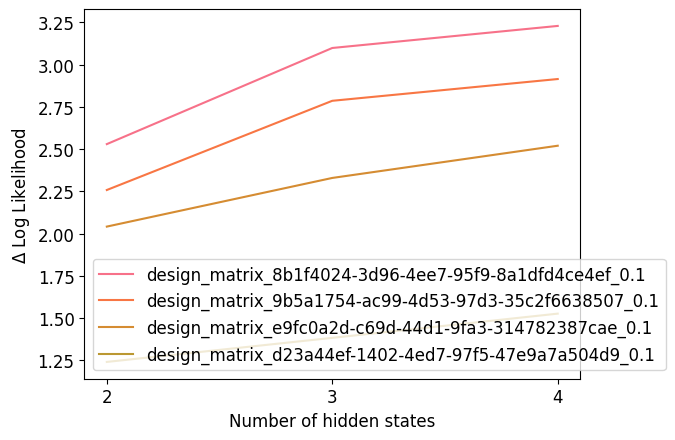

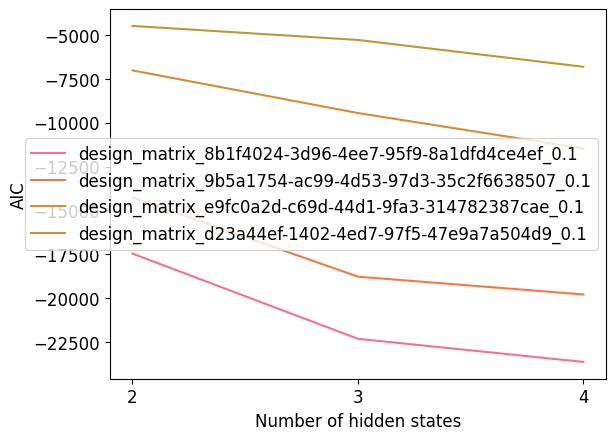

In [13]:
States = np.arange(2, last_state, 1)

def generate_colors(num_colors):
    # Use seaborn's color_palette to generate a list of colors
    return sns.color_palette('husl', n_colors=num_colors)

# Generate the list of colors
colors = generate_colors(len(matrix_all))
Ks = np.array([(num_states + num_states*num_states + num_states*emission_dim*2) 
          for num_states in States])  # pi_init + transition_matrix + predictors_mean + predictors_var 

for s, session in enumerate(design_matrices[0:4]):
    avg_val_lls = all_lls[s]
    baseline_lls = all_baseline_lls[s]
    bits_LL = (np.array(avg_val_lls) - np.array(baseline_lls)) / fold_len * np.log(2)
    
    plt.plot(all_num_states, bits_LL, color=colors[s], label=str(session))
    plt.legend()
    plt.xticks(States)
    plt.xlabel("Number of hidden states")
    plt.ylabel("$\Delta$ Log Likelihood ")
plt.legend()
plt.show()

for s, session in enumerate(design_matrices[0:4]):
    avg_val_lls = all_lls[s]
    baseline_lls = all_baseline_lls[s]
    AIC = Ks * 2 - 2 * np.array(avg_val_lls)
    
    plt.plot(all_num_states, AIC, color=colors[s], label=str(session))
    plt.legend()
    plt.xticks(States)
    plt.xlabel("Number of hidden states")
    plt.ylabel("AIC")
plt.legend()


/tmp/ipykernel_17970/4059448285.py:2: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-ko" (-> color='k'). The keyword argument will take precedence.
  plt.plot(all_num_states, delta_LL, '-ko', color='black')


Text(0, 0.5, '$\\Delta$ Log Likelihood ')

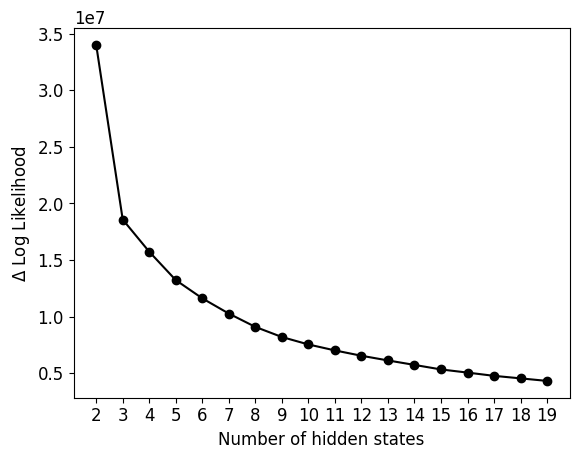

In [116]:
#plt.plot(all_num_states, baselineAIC, '-ko')
plt.plot(all_num_states, delta_LL, '-ko', color='black')
#plt.plot(all_num_states, delta_AIC, '-ko', color='green')

plt.xticks(States)
plt.xlabel("Number of hidden states")
plt.ylabel("$\Delta$ Log Likelihood ")

Text(0, 0.5, 'AIC ')

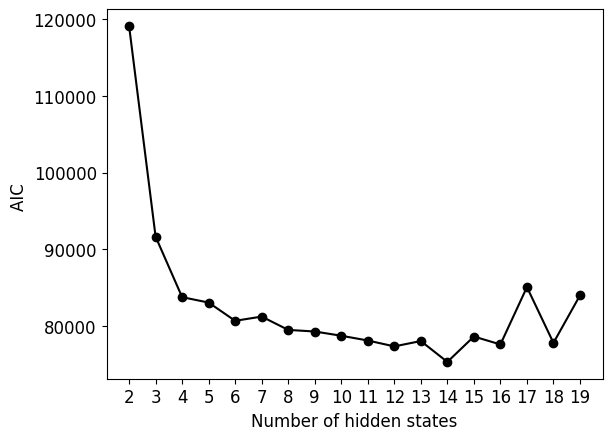

In [117]:
plt.plot(all_num_states, AIC, '-ko')
plt.xticks(States)
plt.xlabel("Number of hidden states")
plt.ylabel("AIC ")

Text(0, 0.5, 'avg. validation log prob.')

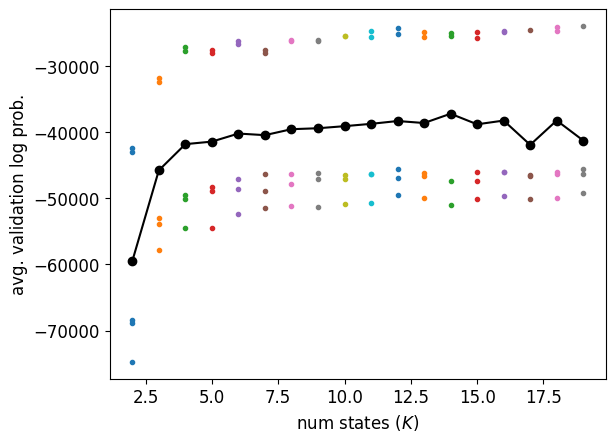

In [118]:
plt.plot(all_num_states, avg_val_lls, '-ko')
for k, per_fold_val_lls in zip(all_num_states, all_val_lls):
    plt.plot(k * jnp.ones_like(per_fold_val_lls), per_fold_val_lls, '.')
plt.xlabel("num states ($K$)")
plt.ylabel("avg. validation log prob.")

Text(0, 0.5, 'avg. validation baseline model')

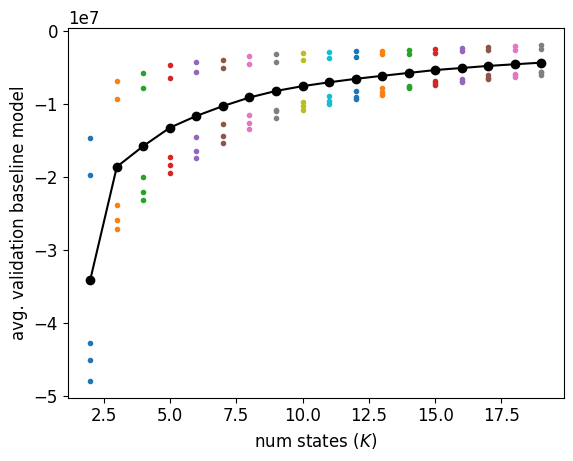

In [120]:
plt.plot(all_num_states, np.nanmean(baseline_lls, axis=1), '-ko')
for k, per_fold_val_lls in zip(all_num_states, baseline_lls):
    plt.plot(k * jnp.ones_like(per_fold_val_lls), per_fold_val_lls, '.')
plt.xlabel("num states ($K$)")
plt.ylabel("avg. validation baseline model")

## Fit optimal-state Gaussian HMM

In [7]:
num_states = 3  #This needs to be chosen manually!

Fitting session 8b1f4024-3d96-4ee7-95f9-8a1dfd4ce4ef


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


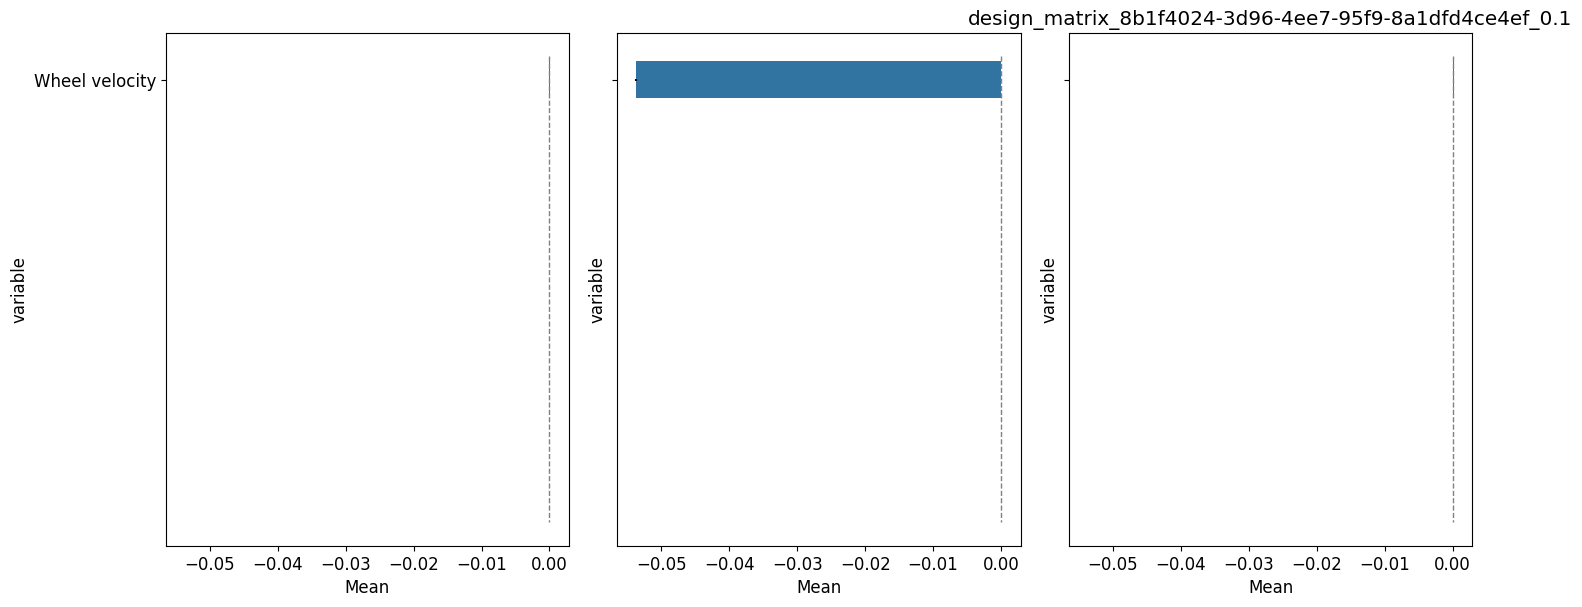

In [10]:
# Fit model for optimal number of states

# Initialize vars for saving best K results
all_init_params = defaultdict(list)
all_fit_params = defaultdict(list)

for s, ses in enumerate(design_matrices[0:1]):
    session = session_all[ses]
    print('Fitting session ' + str(ses[14:-4]))

    matrix = matrix_all[ses][0]
    
    shortened_array = np.array(matrix[:(num_timesteps // num_train_batches) * num_train_batches])
    emission_dim = np.shape(matrix)[1]
    train_emissions = jnp.stack(jnp.split(shortened_array, num_train_batches))
    test_hmm = GaussianHMM(num_states, emission_dim, transition_matrix_stickiness=10.)
    val_lls, fit_params, init_params, baseline_lls = cross_validate_model(test_hmm, jr.PRNGKey(0), train_emissions, num_train_batches)
    
    
    # TODO: Plot uncertainty around estimates of each mean (related with cross-validation);
    # TODO: Plot estimates for variance on a separate plot, with uncertainty associated

    states = ('State 0', "State 1", "State 2", 'State 3') 
    states = ('State 0', "State 1", 'State 2') 

    fig, ax = plt.subplots(ncols=len(states) , nrows=1, sharex=True, sharey=True, figsize=[15, 6])
    plt.rc('font', size=12)

    state_means = pd.DataFrame({
    'Wheel velocity': np.mean(fit_params[2].means[:].T[0], axis=1),
    'Pupil diameter': np.mean(fit_params[2].means[:].T[1], axis=1),
    'Whisker motion energy': np.mean(fit_params[2].means[:].T[2], axis=1),
    'Nose speed X': np.mean(fit_params[2].means[:].T[3], axis=1),
    'Nose speed Y': np.mean(fit_params[2].means[:].T[4], axis=1),
    'Left paw speed X': np.mean(fit_params[2].means[:].T[5], axis=1),
    'Left paw speed Y': np.mean(fit_params[2].means[:].T[6], axis=1),
    'Pupil speed X': np.mean(fit_params[2].means[:].T[7], axis=1),
    'Pupil speed Y': np.mean(fit_params[2].means[:].T[8], axis=1),
    'Licks': np.mean(fit_params[2].means[:].T[9], axis=1),
    })
    state_std = pd.DataFrame({
    'Wheel velocity': np.std(fit_params[2].means[:].T[0], axis=1),
    'Pupil diameter': np.std(fit_params[2].means[:].T[1], axis=1),
    'Whisker motion energy': np.std(fit_params[2].means[:].T[2], axis=1),
    'Nose speed X': np.std(fit_params[2].means[:].T[3], axis=1),
    'Nose speed Y': np.std(fit_params[2].means[:].T[4], axis=1),
    'Left paw speed X': np.std(fit_params[2].means[:].T[5], axis=1),
    'Left paw speed Y': np.std(fit_params[2].means[:].T[6], axis=1),
    'Pupil speed X': np.std(fit_params[2].means[:].T[7], axis=1),
    'Pupil speed Y': np.std(fit_params[2].means[:].T[8], axis=1),
    'Licks': np.std(fit_params[2].means[:].T[9], axis=1),
    })

    """
    state_means = pd.DataFrame({
    'Wheel velocity': np.mean(fit_params[2].means[:].T[0], axis=1),
    })
    state_std = pd.DataFrame({
    'Wheel velocity': np.std(fit_params[2].means[:].T[0], axis=1),
    })
    """

    # Standardize so that values vary between -1 and 1
    for c, column in enumerate(state_means.keys()[:-1]):
        
        # Calculate min and max values
        min_value = state_means[column].min()
        max_value = state_means[column].max()

        # Standardize values between -1 and 1
        #state_means[column] = (state_means[column] - min_value) / (max_value - min_value) * 2 - 1
        
        
    state_means['State'] = np.arange(0, len(states))

    melted_state_means = pd.melt(state_means, id_vars =['State'], value_vars=np.array(state_means.keys()[:-1]))
    melted_state_means['error'] = state_std['Wheel velocity']
    for s, state in enumerate(states):
        use_data = melted_state_means.loc[melted_state_means['State']==s]
        sns.barplot(y='variable', x='value', data=use_data, ax=ax[s], yerr=use_data['error'])
        #ax[s].set_yticklabels(np.array(state_means.keys()[:-1]), rotation=45)
        ax[s].vlines(0, -.50, 9.5, color='Gray', linestyles='--', linewidth=1)
        ax[s].set_xlabel('Mean')
        #ax[s].set_title(state)

    plt.tight_layout()
    plt.title(ses)
    plt.show()
    

### Plot results

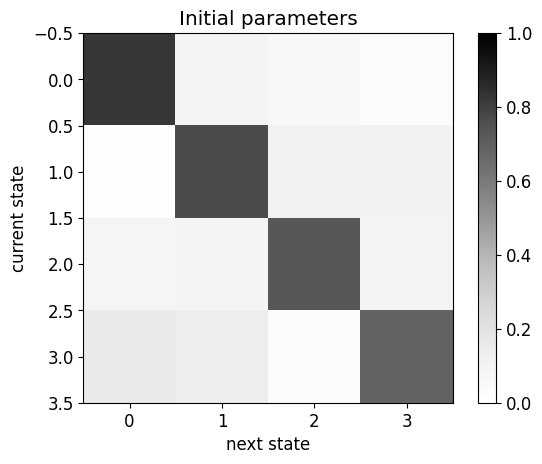

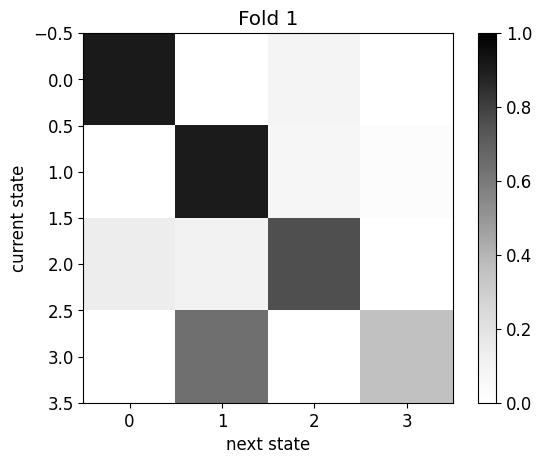

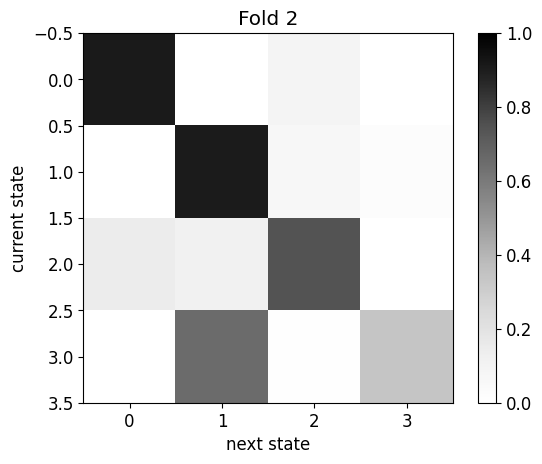

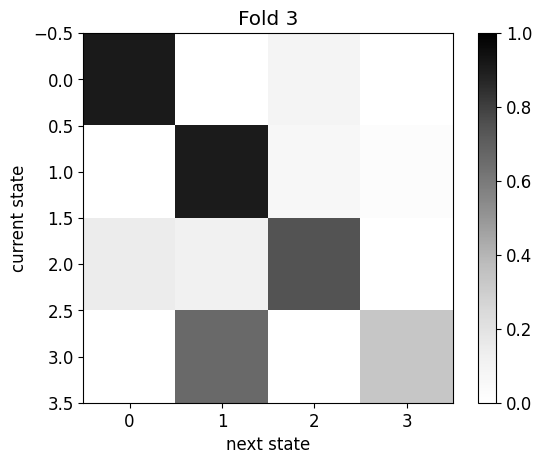

Array([[9.0734458e-01, 7.1028230e-04, 9.1937467e-02, 7.7039131e-06],
       [7.6419001e-06, 9.0575910e-01, 6.8851024e-02, 2.5382234e-02],
       [1.4591575e-01, 1.1145600e-01, 7.4253851e-01, 8.9726505e-05],
       [1.9322814e-04, 6.6256666e-01, 2.5056661e-03, 3.3473444e-01]],      dtype=float32)

In [157]:
plt.title('Initial parameters')
plot_transition_matrix(init_params[1].transition_matrix)
init_params[1].transition_matrix

plt.title('Fold 1')
plot_transition_matrix(fit_params[1].transition_matrix[0])
fit_params[1].transition_matrix[0]
plt.title('Fold 2')
plot_transition_matrix(fit_params[1].transition_matrix[1])
fit_params[1].transition_matrix[1]
plt.title('Fold 3')
plot_transition_matrix(fit_params[1].transition_matrix[2])
fit_params[1].transition_matrix[2]


## Find best fold

In [5]:
# Plotting params
bin_size = 0.1
multiplier = 1/bin_size

init = -10
end = 15

event_type_list = ['goCueTrigger_times', 'feedback_times', 'firstMovement_times']
event_type_name = ['Go cue', 'Feedback time', 'First movement onset']

Fitting session 8b1f4024-3d96-4ee7-95f9-8a1dfd4ce4ef


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


3


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


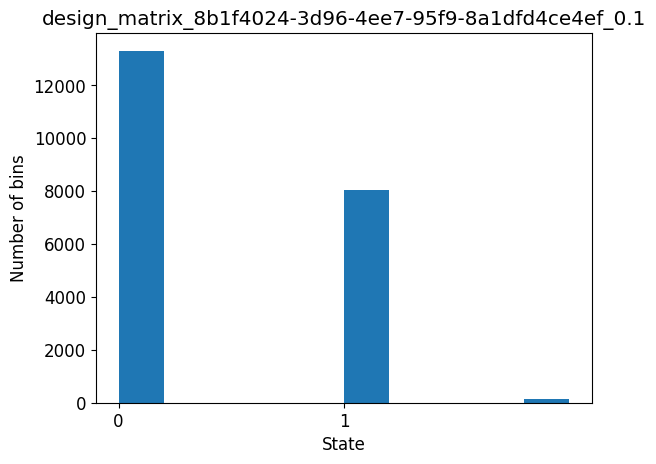

/home/ines/repositories/representation_learning_variability/Models/Sub-trial/2_fit_models/plotting_functions.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  reduced_design_matrix = design_matrix[:test_length*2].append(design_matrix[-test_length*2:])


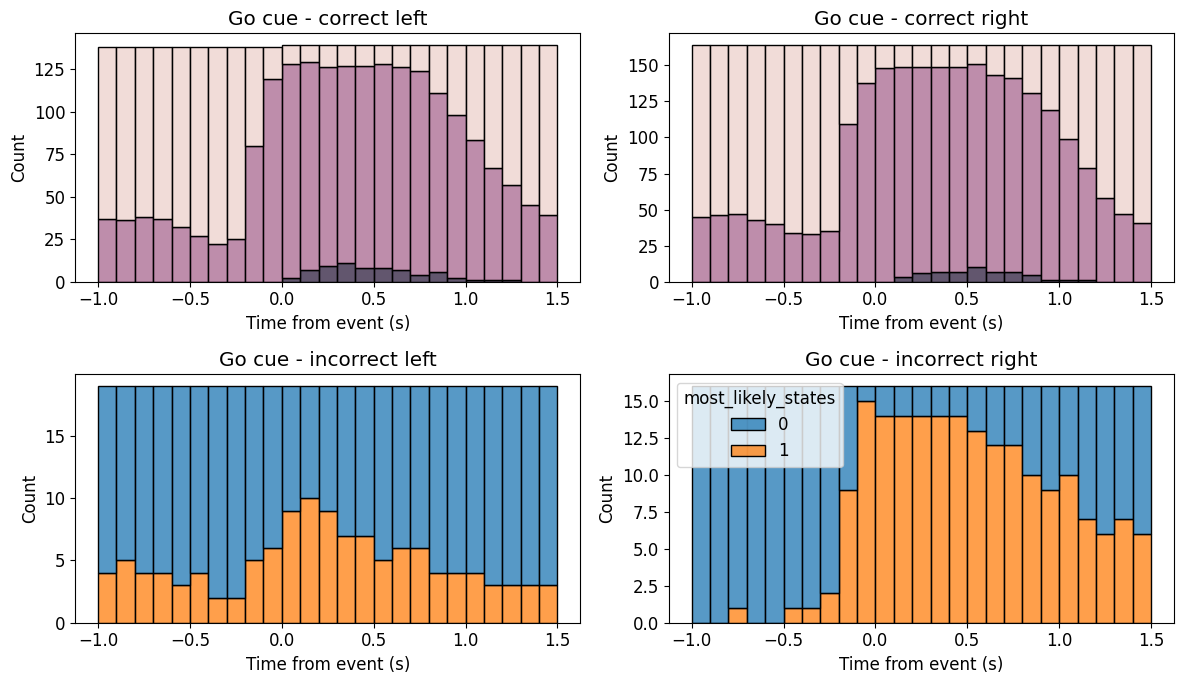

/home/ines/repositories/representation_learning_variability/Models/Sub-trial/2_fit_models/plotting_functions.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  reduced_design_matrix = design_matrix[:test_length*2].append(design_matrix[-test_length*2:])


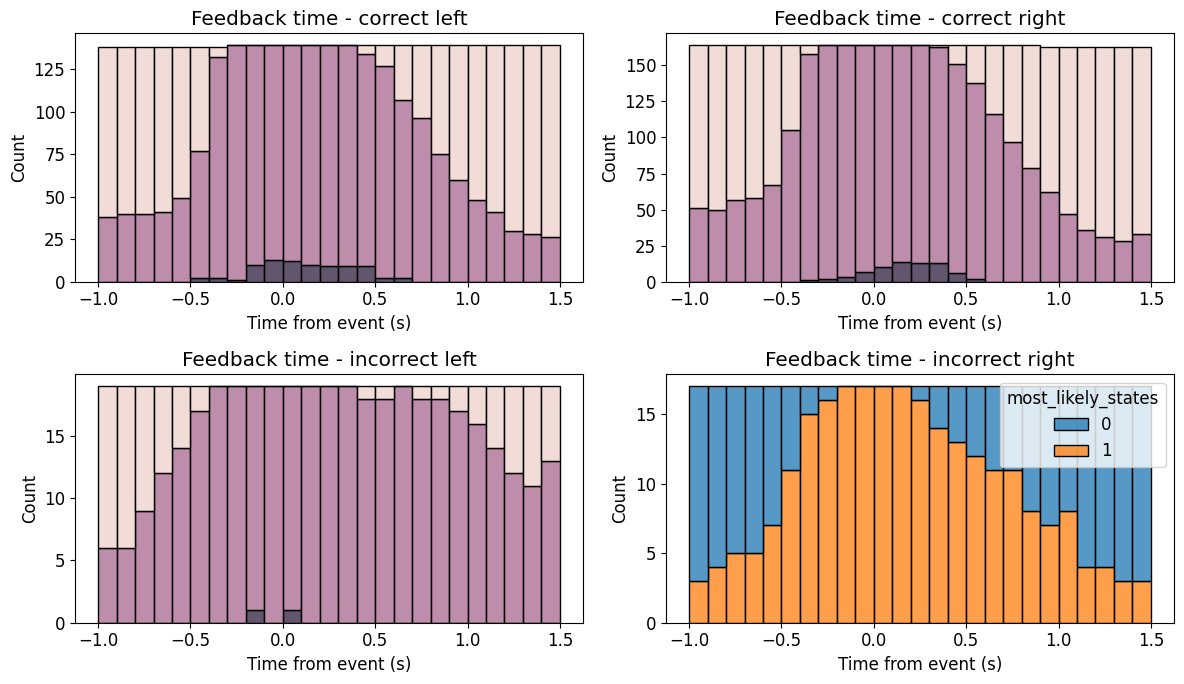

/home/ines/repositories/representation_learning_variability/Models/Sub-trial/2_fit_models/plotting_functions.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  reduced_design_matrix = design_matrix[:test_length*2].append(design_matrix[-test_length*2:])


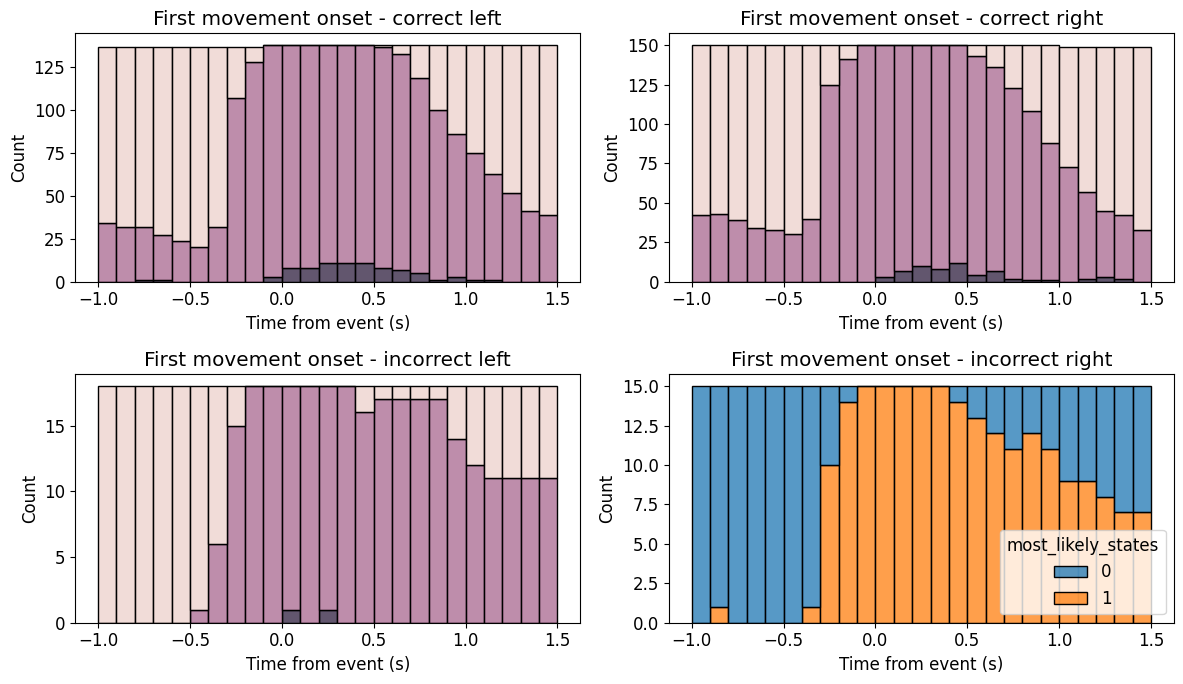

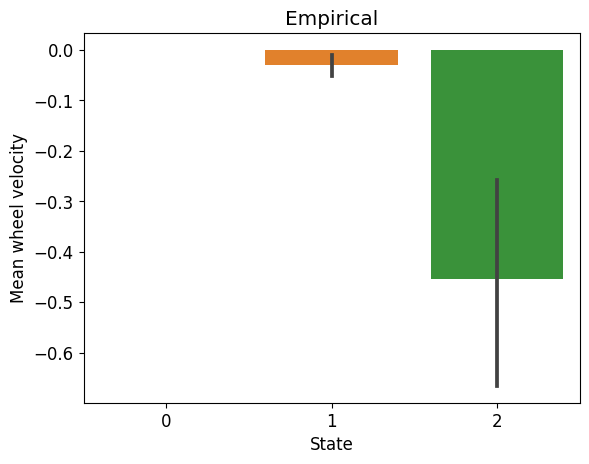

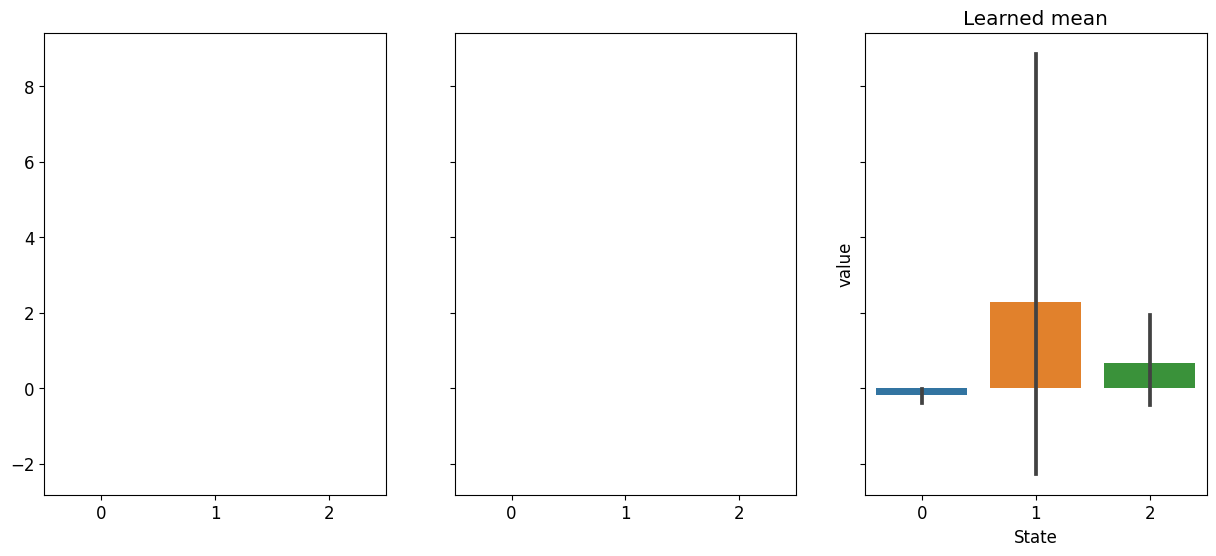

Fitting session 9b5a1754-ac99-4d53-97d3-35c2f6638507


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


4


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


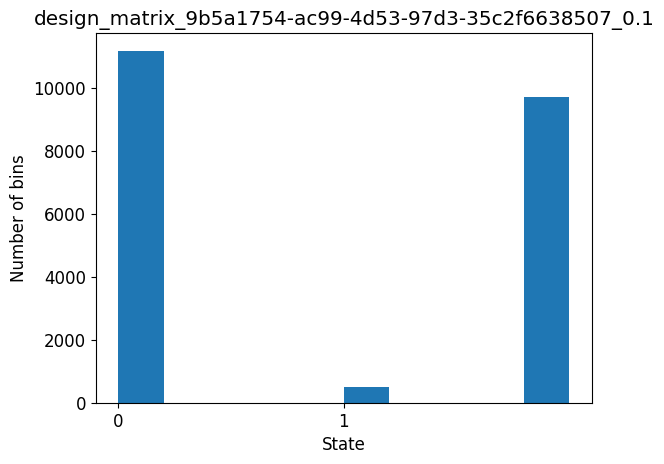

/home/ines/repositories/representation_learning_variability/Models/Sub-trial/2_fit_models/plotting_functions.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  reduced_design_matrix = design_matrix[:test_length*2].append(design_matrix[-test_length*2:])


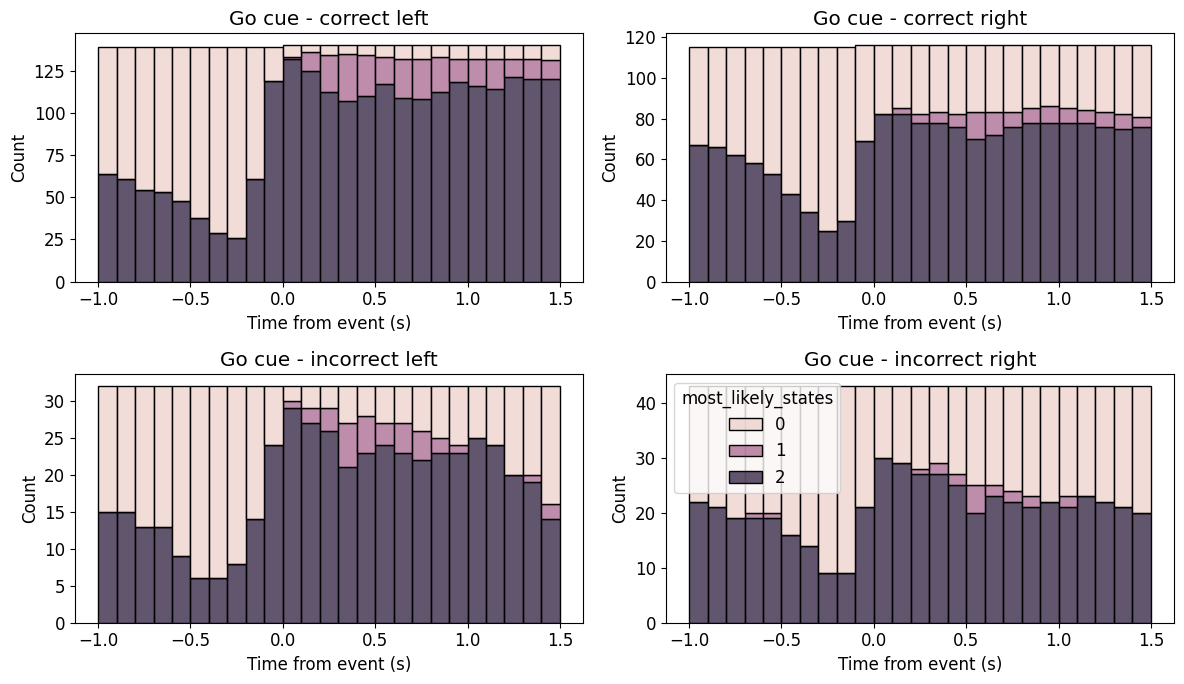

/home/ines/repositories/representation_learning_variability/Models/Sub-trial/2_fit_models/plotting_functions.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  reduced_design_matrix = design_matrix[:test_length*2].append(design_matrix[-test_length*2:])


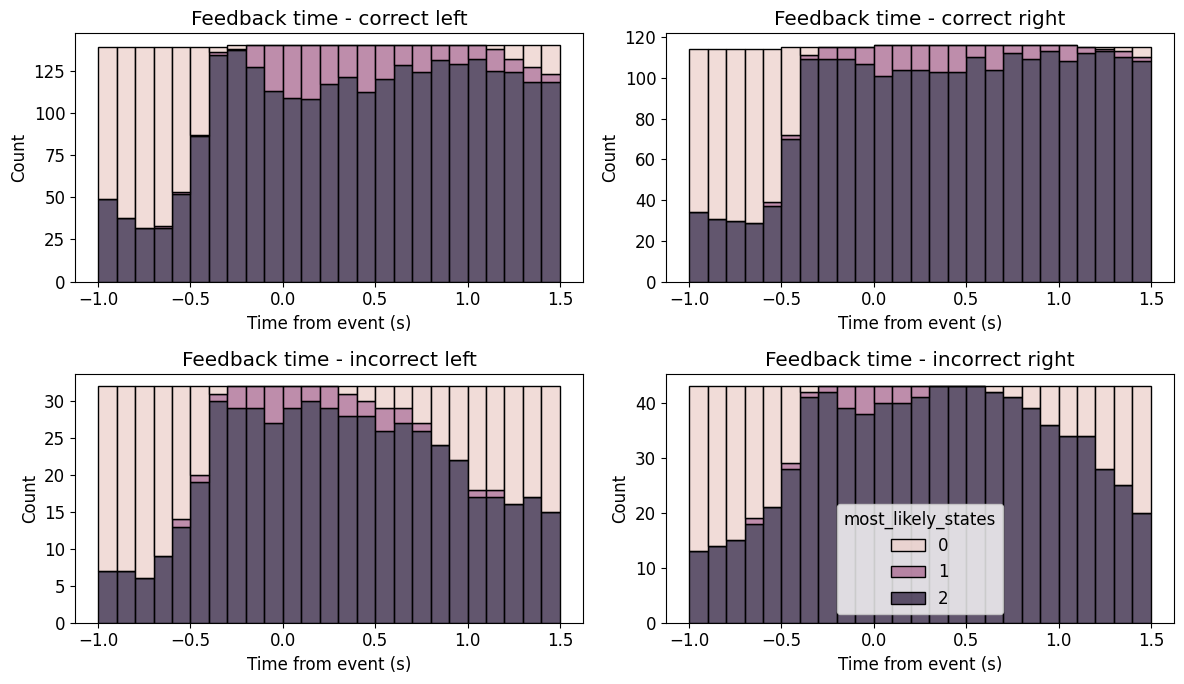

/home/ines/repositories/representation_learning_variability/Models/Sub-trial/2_fit_models/plotting_functions.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  reduced_design_matrix = design_matrix[:test_length*2].append(design_matrix[-test_length*2:])


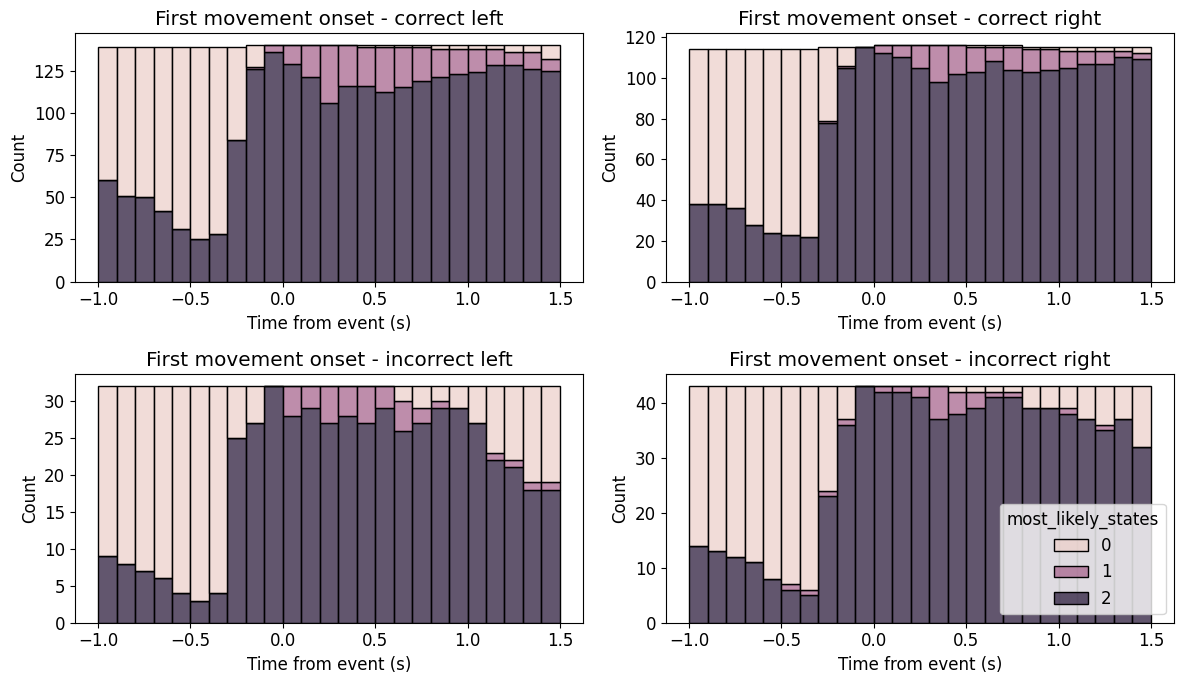

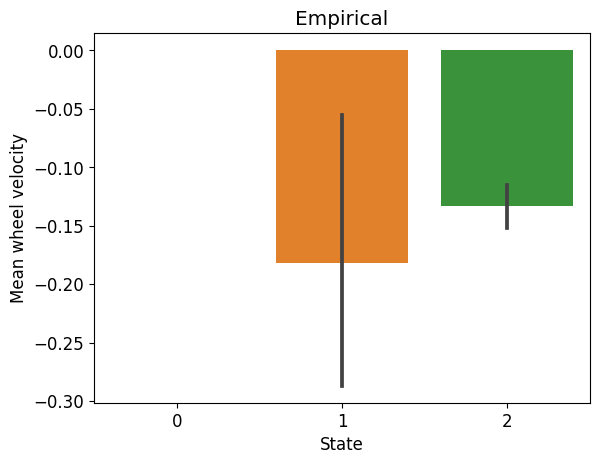

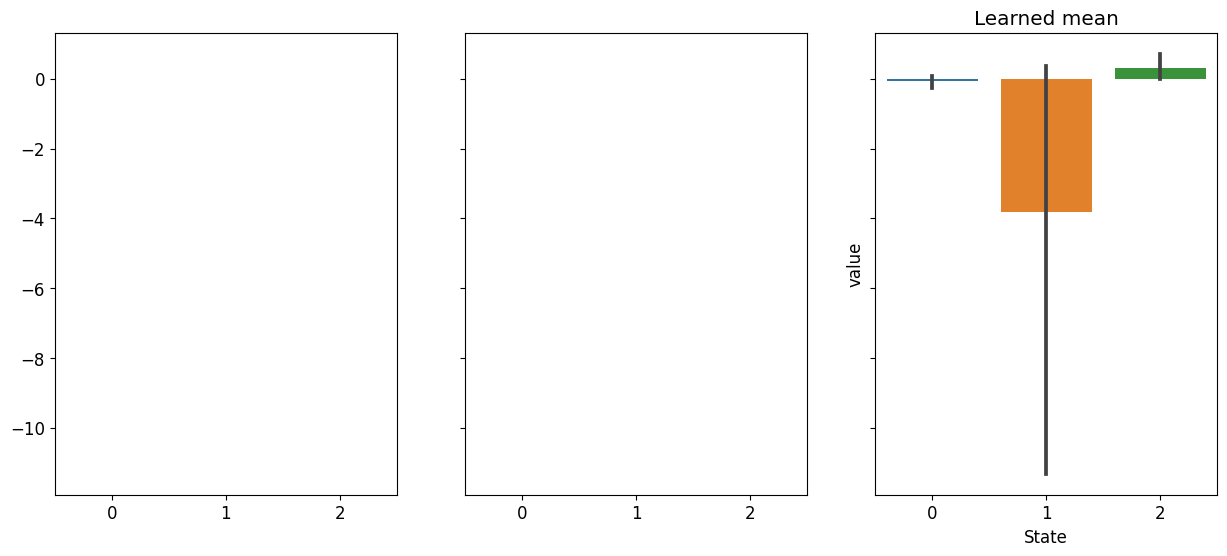

Fitting session e9fc0a2d-c69d-44d1-9fa3-314782387cae


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


4


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


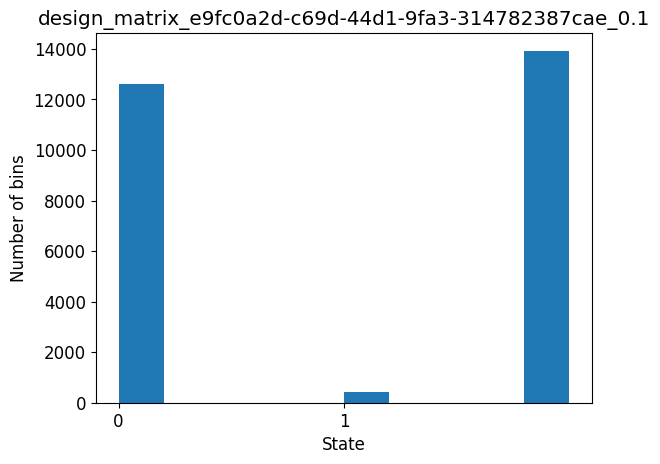

/home/ines/repositories/representation_learning_variability/Models/Sub-trial/2_fit_models/plotting_functions.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  reduced_design_matrix = design_matrix[:test_length*2].append(design_matrix[-test_length*2:])


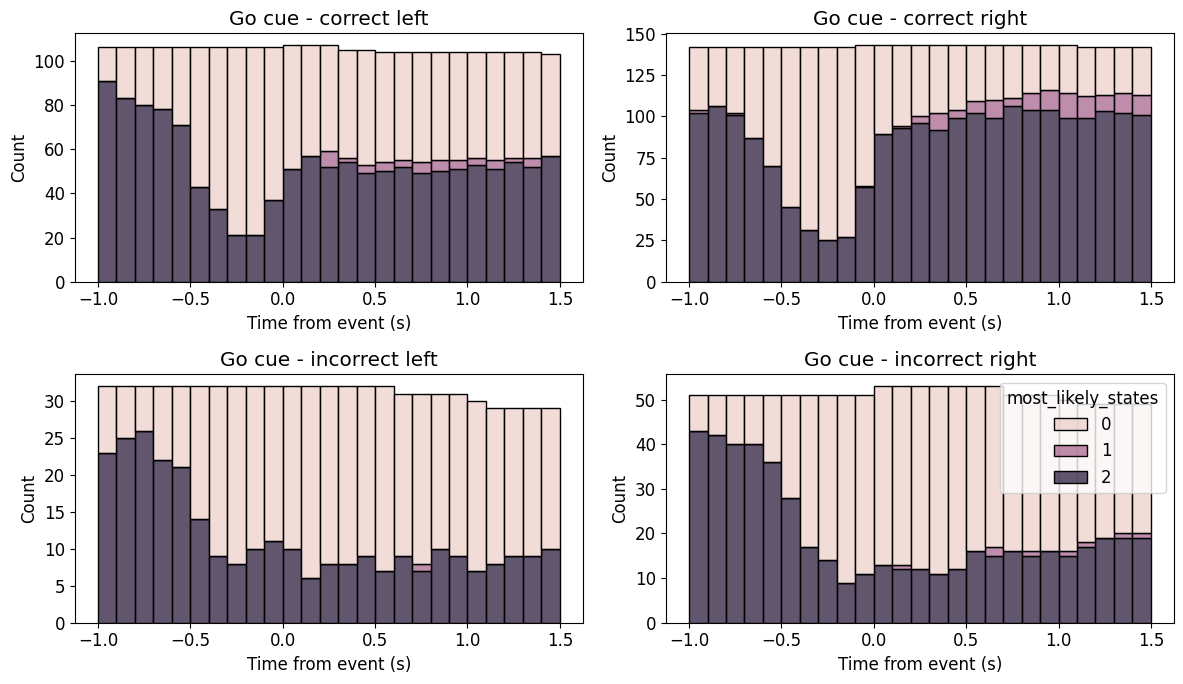

/home/ines/repositories/representation_learning_variability/Models/Sub-trial/2_fit_models/plotting_functions.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  reduced_design_matrix = design_matrix[:test_length*2].append(design_matrix[-test_length*2:])


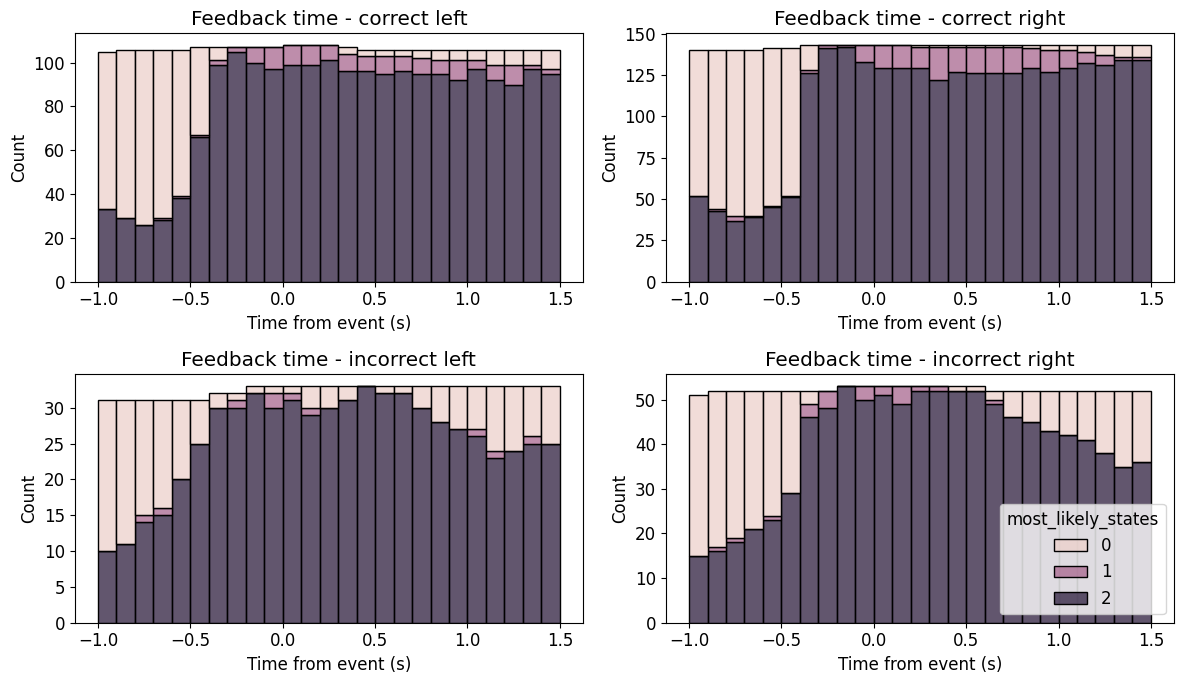

/home/ines/repositories/representation_learning_variability/Models/Sub-trial/2_fit_models/plotting_functions.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  reduced_design_matrix = design_matrix[:test_length*2].append(design_matrix[-test_length*2:])


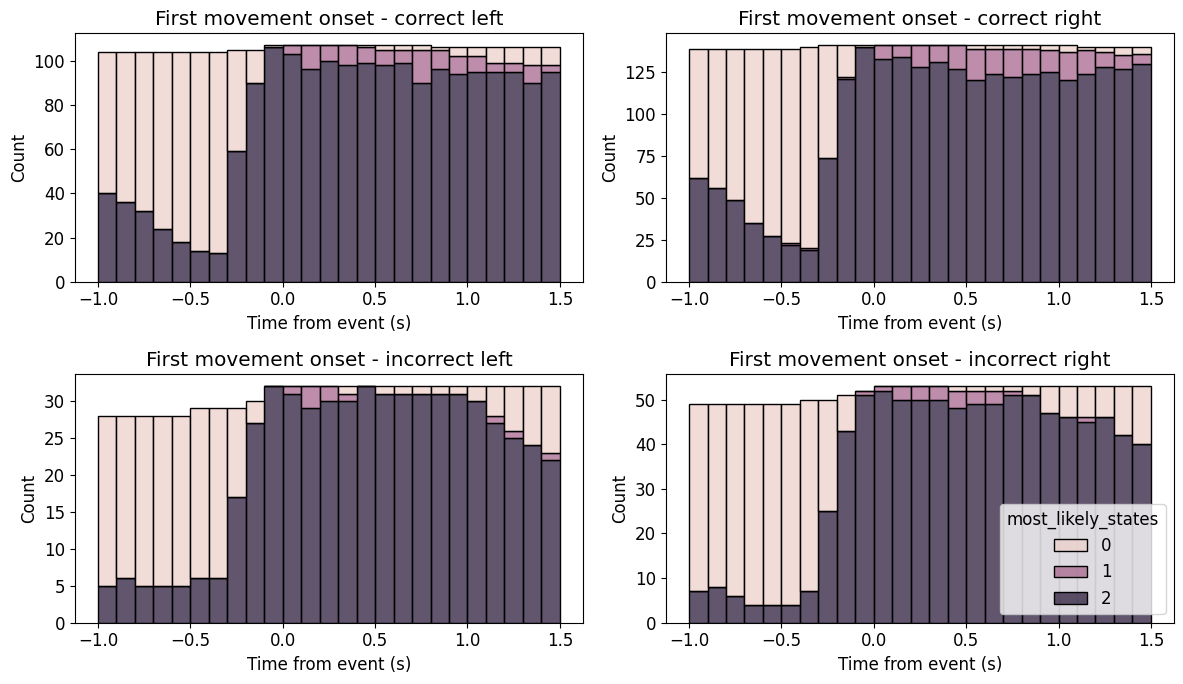

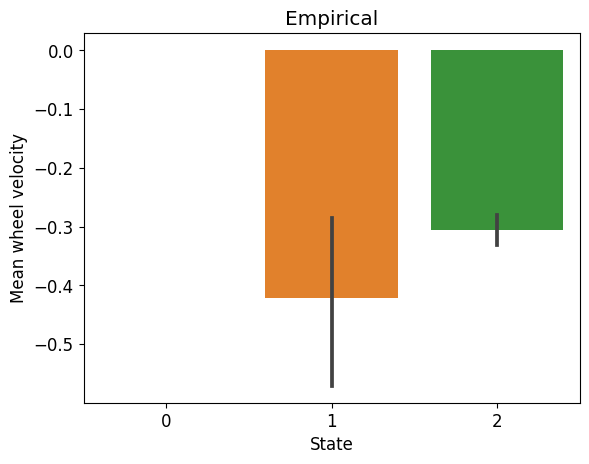

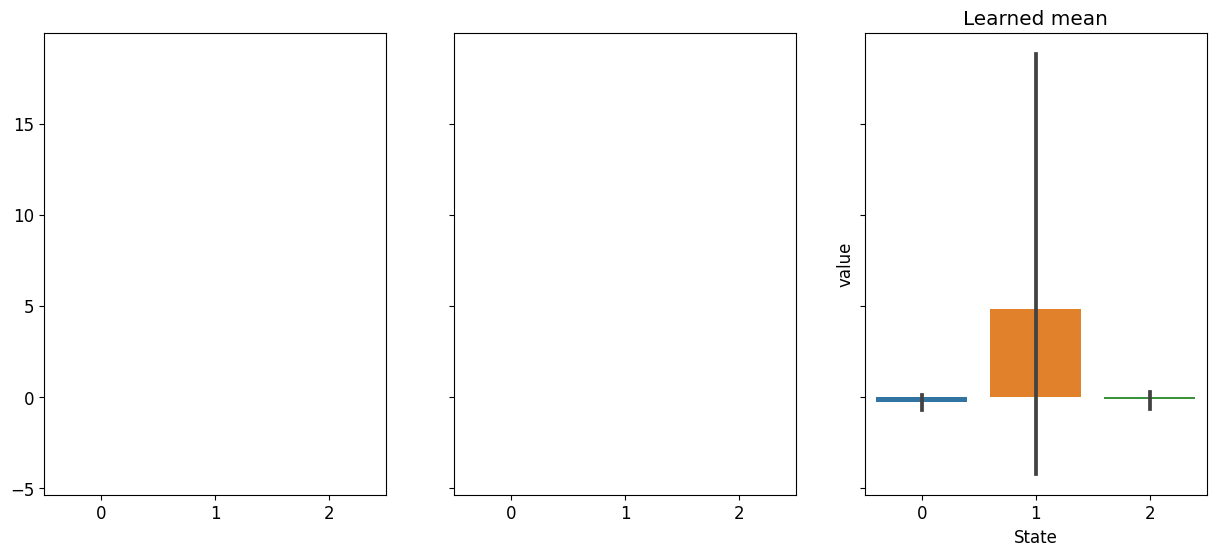

Fitting session d23a44ef-1402-4ed7-97f5-47e9a7a504d9


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


4


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


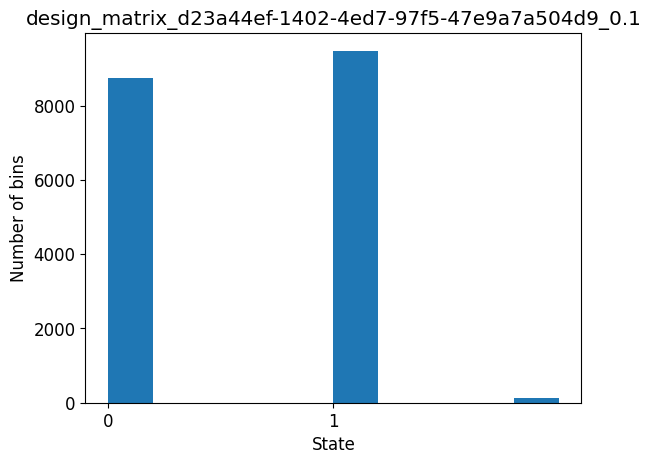

/home/ines/repositories/representation_learning_variability/Models/Sub-trial/2_fit_models/plotting_functions.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  reduced_design_matrix = design_matrix[:test_length*2].append(design_matrix[-test_length*2:])


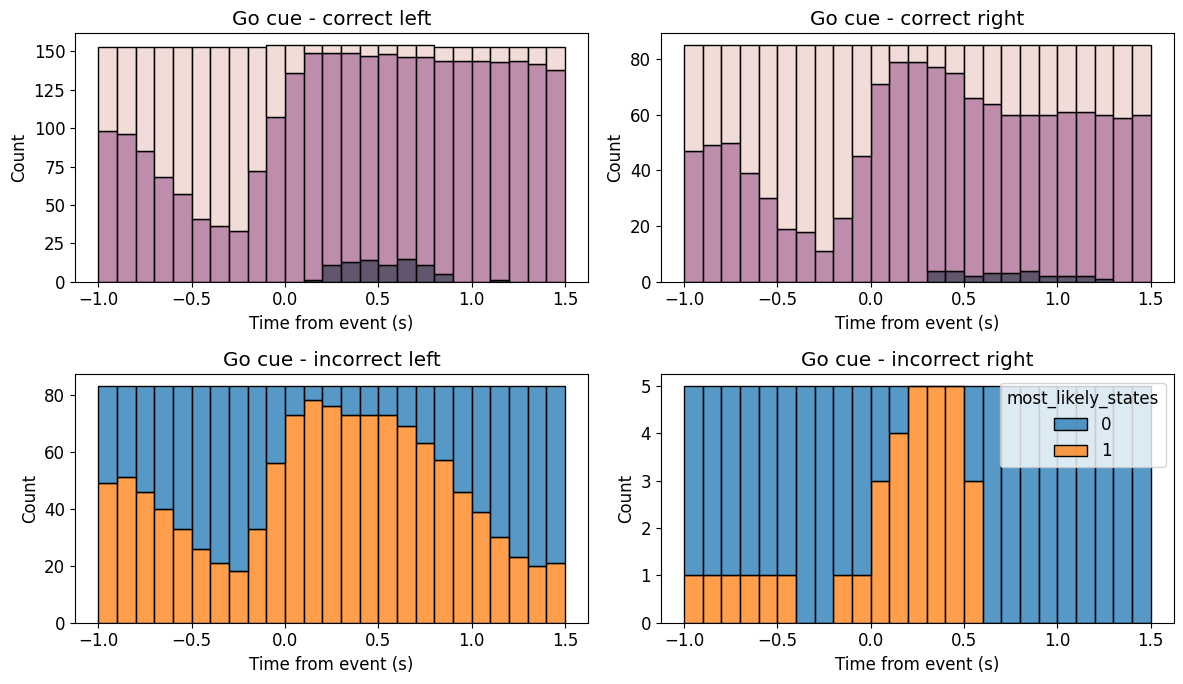

/home/ines/repositories/representation_learning_variability/Models/Sub-trial/2_fit_models/plotting_functions.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  reduced_design_matrix = design_matrix[:test_length*2].append(design_matrix[-test_length*2:])


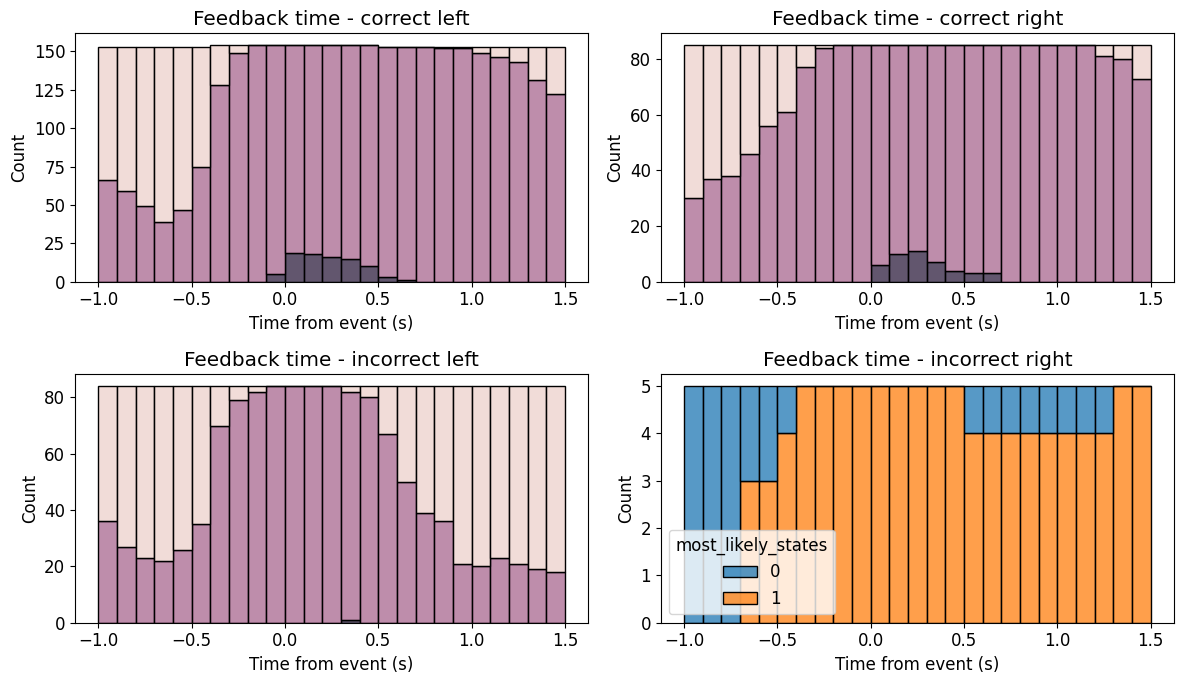

/home/ines/repositories/representation_learning_variability/Models/Sub-trial/2_fit_models/plotting_functions.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  reduced_design_matrix = design_matrix[:test_length*2].append(design_matrix[-test_length*2:])


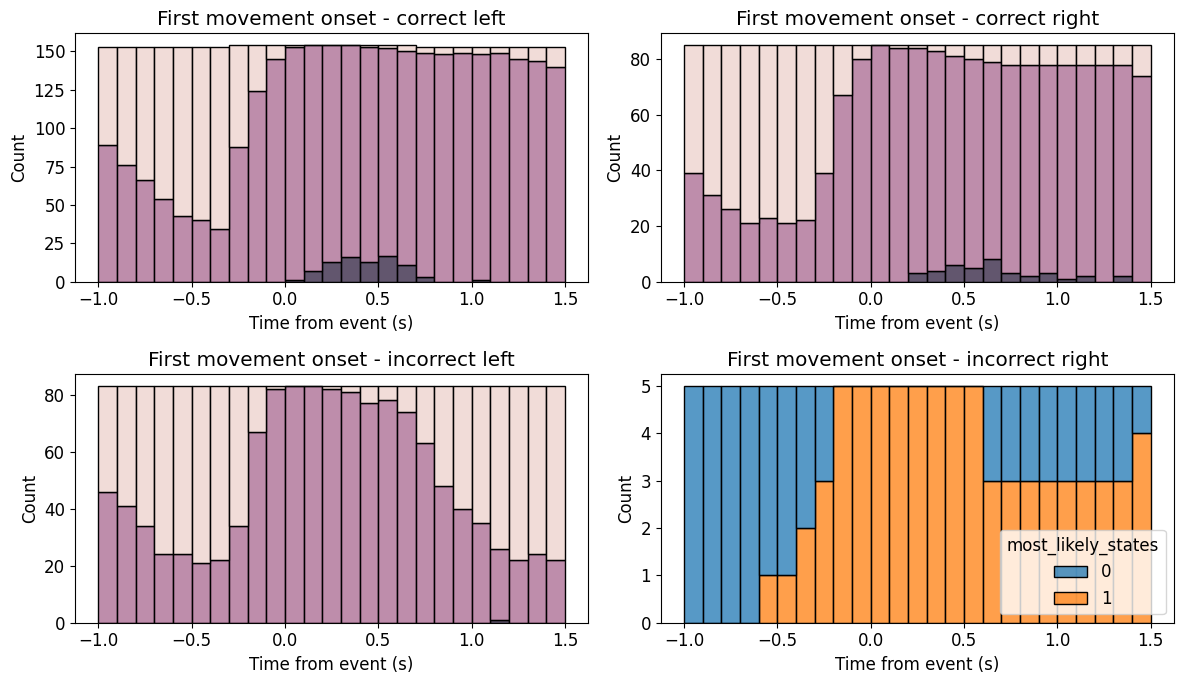

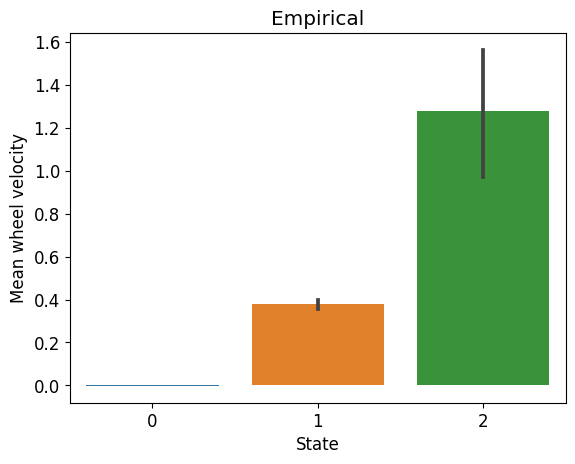

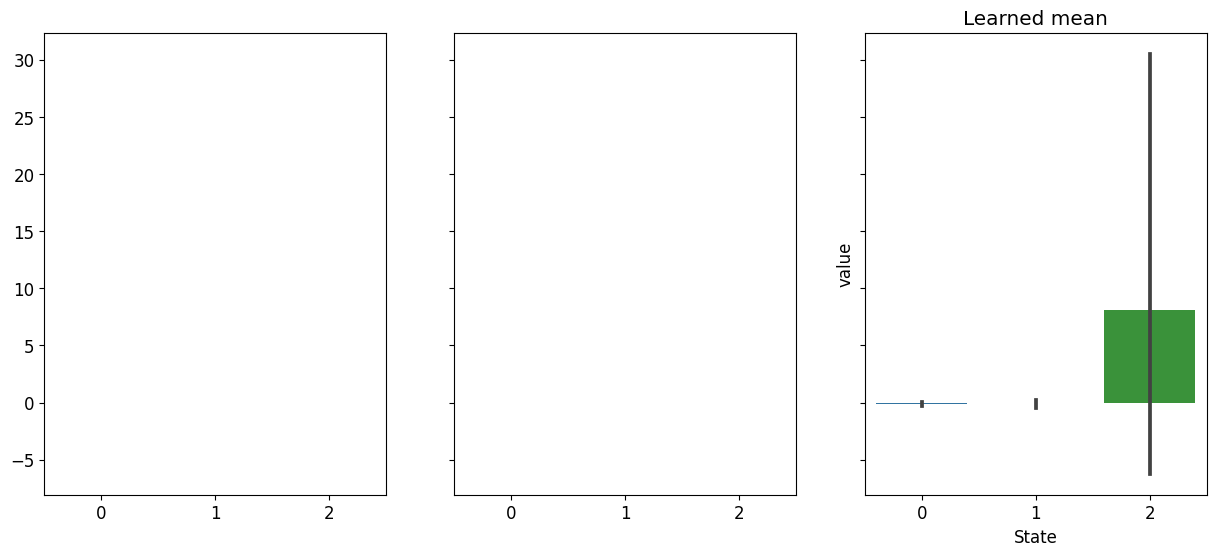

In [14]:
# Fit model for optimal number of states

for s, ses in enumerate(design_matrices[0:4]):
    session_trials = session_all[ses]
    print('Fitting session ' + str(ses[14:-4]))
    
    # Trials data
    session = design_matrices[s][14:-4]
    session_trials = one.load_object(session, obj='trials', namespace='ibl')
    session_trials = session_trials.to_df()
    session_length = list(session_trials['stimOff_times'][-1:])[0]  # TODO: this might not work if stimOff times are missing

    big_design_matrix = pickle.load(open(ses, "rb"))
    var_names = ['avg_wheel_vel', 'pupil_diameter',
       'whisker_me', 'nose_speed_X', 'nose_speed_Y', 
       'l_paw_speed_X', 'l_paw_speed_Y', 'pupil_speed_X',
       'pupil_speed_Y', 'Gaussian_licks']
    var_names = ['avg_wheel_vel']
    
    design_matrix = big_design_matrix.groupby('Bin')[var_names].mean()  # 
    design_matrix = design_matrix.reset_index(level=[0])  # , 'Onset times'
    design_matrix = design_matrix.dropna()
    
    # Trim design matrix to be as long as the session (otherwise it will include task-unrelated behavior)
    design_matrix = design_matrix.loc[design_matrix['Bin']<session_length*10]
    
    " Fit model "
    # Fit again (TODO: should save these results from the code above)
    num_timesteps = np.shape(matrix_all[ses][0])[0]
    emission_dim = np.shape(matrix_all[ses][0])[1]
    shortened_array = np.array(matrix_all[ses][0][:(num_timesteps // num_train_batches) * num_train_batches])
    train_emissions = jnp.stack(jnp.split(shortened_array, num_train_batches))
   
    test_hmm = GaussianHMM(num_states, emission_dim, transition_matrix_stickiness=10.)
    val_lls, fit_params, init_params, baseline_lls = cross_validate_model(test_hmm, jr.PRNGKey(0), train_emissions, num_train_batches)

    " Find best fold (this is what Zoe does) results "
    use_fold = np.where(val_lls==np.max(val_lls))[0][0]
    #use_train = jnp.concatenate([train_emissions[:use_fold-1], train_emissions[use_fold:]])
    #use_val = train_emissions[use_fold]
    print(use_fold)
        
    # Find parameters for best fold
    initial_probs = fit_params[0].probs[use_fold]
    transition_matrix = fit_params[1].transition_matrix[use_fold]
    emission_means = fit_params[2].means[use_fold]
    emission_covs = fit_params[2].covs[use_fold]
        
    # Initialize new hmm
    new_hmm = GaussianHMM(num_states, emission_dim, transition_matrix_stickiness=10.)
    best_fold_params, props = new_hmm.initialize(key=jr.PRNGKey(0), method="kmeans", initial_probs=initial_probs,
                                    transition_matrix=transition_matrix,
                                    emission_means=emission_means,
                                    emission_covariances=emission_covs,
                                    emissions=matrix_all[ses][0])  # not sure if I need to include  

    # Get state estimates for validation data
    most_likely_states = new_hmm.most_likely_states(best_fold_params, matrix_all[ses][0])
    
    # PLot frequencey of most_likely_states
    plt.hist(most_likely_states)
    plt.xlabel('State')
    plt.xticks(np.arange(0, np.max(most_likely_states), 1), np.arange(0, np.max(most_likely_states), 1))
    plt.ylabel('Number of bins')
    plt.title(ses)
    plt.show()
    
    
    """ Plot states per trial type, aligned on events """
    test_set = test_all[ses][0]
    plot_states_aligned(init, end, event_type_list, event_type_name, session_trials, design_matrix, test_set, most_likely_states, bin_size, multiplier)
    
    """ Plot fit parameters """
    
    states = ('State 0', "State 1", "State 2", 'State 3') 
    states = ('State 0', "State 1", 'State 2') 
    fig, ax = plt.subplots(ncols=len(states) , nrows=1, sharex=True, sharey=True, figsize=[15, 6])
    plt.rc('font', size=12)

    state_means = pd.DataFrame({
    'Wheel velocity': np.mean(fit_params[2].means[:].T[0], axis=1),
    'Pupil diameter': np.mean(fit_params[2].means[:].T[1], axis=1),
    'Whisker motion energy': np.mean(fit_params[2].means[:].T[2], axis=1),
    'Nose speed X': np.mean(fit_params[2].means[:].T[3], axis=1),
    'Nose speed Y': np.mean(fit_params[2].means[:].T[4], axis=1),
    'Left paw speed X': np.mean(fit_params[2].means[:].T[5], axis=1),
    'Left paw speed Y': np.mean(fit_params[2].means[:].T[6], axis=1),
    'Pupil speed X': np.mean(fit_params[2].means[:].T[7], axis=1),
    'Pupil speed Y': np.mean(fit_params[2].means[:].T[8], axis=1),
    'Licks': np.mean(fit_params[2].means[:].T[9], axis=1),
    })
    state_std = pd.DataFrame({
    'Wheel velocity': np.std(fit_params[2].means[:].T[0], axis=1),
    'Pupil diameter': np.std(fit_params[2].means[:].T[1], axis=1),
    'Whisker motion energy': np.std(fit_params[2].means[:].T[2], axis=1),
    'Nose speed X': np.std(fit_params[2].means[:].T[3], axis=1),
    'Nose speed Y': np.std(fit_params[2].means[:].T[4], axis=1),
    'Left paw speed X': np.std(fit_params[2].means[:].T[5], axis=1),
    'Left paw speed Y': np.std(fit_params[2].means[:].T[6], axis=1),
    'Pupil speed X': np.std(fit_params[2].means[:].T[7], axis=1),
    'Pupil speed Y': np.std(fit_params[2].means[:].T[8], axis=1),
    'Licks': np.std(fit_params[2].means[:].T[9], axis=1),
    })

    """
    state_means = pd.DataFrame({
    'Wheel velocity': np.mean(fit_params[2].means[:].T[0], axis=1),
    })
    state_std = pd.DataFrame({
    'Wheel velocity': np.std(fit_params[2].means[:].T[0], axis=1),
    })
    """
    state_means['State'] = np.arange(0, len(states))

    melted_state_means = pd.melt(state_means, id_vars =['State'], value_vars=np.array(state_means.keys()[:-1]))
    melted_state_means['error'] = state_std['Wheel velocity']
    sns.barplot(x='State', y='value', data=melted_state_means)
    plt.title('Learned mean')
    plt.show()
    """
    for s, state in enumerate(states):
        use_data = melted_state_means.loc[melted_state_means['State']==s]
        plt.plot()
        sns.barplot(y='variable', x='value', data=use_data, ax=ax[s], yerr=use_data['error'])
        #ax[s].set_yticklabels(np.array(state_means.keys()[:-1]), rotation=45)
        ax[s].vlines(0, -.50, 9.5, color='Gray', linestyles='--', linewidth=1)
        ax[s].set_xlabel('Mean')
        #ax[s].set_title(state)

    plt.tight_layout()
    plt.title(ses)
    plt.show()
    """


In [26]:
# Find best fold (this is what Zoe does) results
use_fold = np.where(val_lls==np.max(val_lls))[0][0]
use_train = jnp.concatenate([train_emissions[:use_fold-1], train_emissions[use_fold:]])

use_val = train_emissions[use_fold]
print(use_fold)

4


### Train new model on the data from best fold

In [123]:
# Initialize new hmm
new_hmm = GaussianHMM(num_states, emission_dim, transition_matrix_stickiness=10.)
params, props = new_hmm.initialize(key=jr.PRNGKey(0), method="kmeans", emissions=use_train)
# Fit model to train data
fit_params, train_lps = new_hmm.fit_em(params, props, use_train, 
                                        num_iters=num_iters, verbose=False)
# Get state estimates for validation data
most_likely_states = new_hmm.most_likely_states(fit_params, use_val)
# Pad states array to have the same size as the whole data
complete_most_likely_states = np.concatenate([np.zeros(len(use_val)*(use_fold))* np.nan, most_likely_states, np.zeros(len(use_val)*(4-use_fold))* np.nan]) # hard-coded for now
# Compute log likelihood on the validation data
lls = new_hmm.marginal_log_prob(fit_params, use_val)

/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


### Alternatively used the parameters from the best fit to get most likely states on the whole training set; no retraining

In [133]:
# Find parameters for best fold
initial_probs = fit_params[0].probs[use_fold]
transition_matrix = fit_params[1].transition_matrix[use_fold]
emission_means = fit_params[2].means[use_fold]
emission_covs = fit_params[2].covs[use_fold]

In [134]:
# Initialize new hmm
new_hmm = GaussianHMM(num_states, emission_dim, transition_matrix_stickiness=10.)
best_fold_params, props = new_hmm.initialize(key=jr.PRNGKey(0), method="kmeans", initial_probs=initial_probs,
                                transition_matrix=transition_matrix,
                                emission_means=emission_means,
                                emission_covariances=emission_covs,
                                emissions=training_set)  # not sure if I need to include  

# Get state estimates for validation data
most_likely_states = new_hmm.most_likely_states(best_fold_params, training_set)

/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [33]:
# Plot the marginal log probs across EM iterations
plt.plot(train_lps)
plt.xlabel("EM iterations")
plt.ylabel("marginal log prob.")
# Use fitted model for posterior inference
post = new_hmm.smoother(params, standardized_matrix[0])
print(post.smoothed_probs.shape) # (1000, 3)

NameError: name 'train_lps' is not defined

#### Plot occupancy of states on validation data

Text(0, 0.5, 'Number of bins')

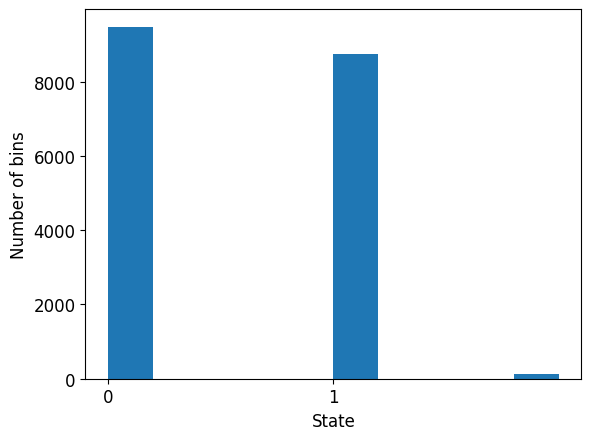

In [138]:
plt.hist(most_likely_states)
plt.xlabel('State')
plt.xticks(np.arange(0, np.max(most_likely_states), 1), np.arange(0, np.max(most_likely_states), 1))
plt.ylabel('Number of bins')

#### Plot states per event and split per side or correct incorrect

/tmp/ipykernel_17970/1860137500.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  reduced_design_matrix = design_matrix[:test_length*2].append(design_matrix[-test_length*2:])


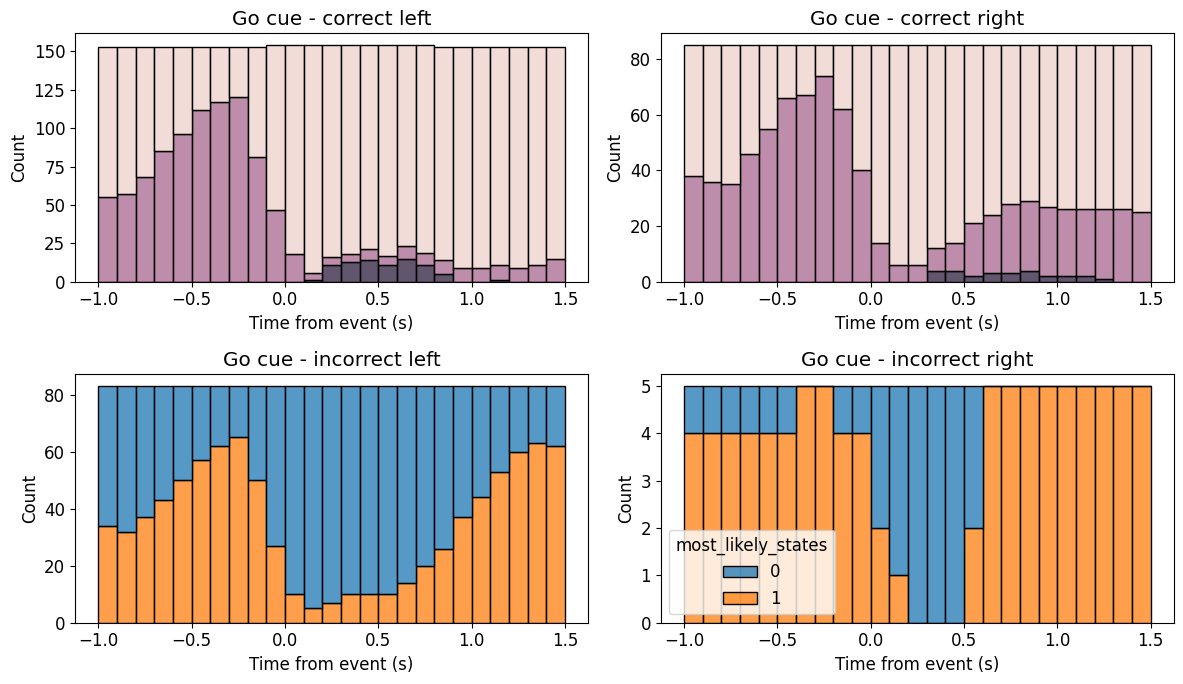

/tmp/ipykernel_17970/1860137500.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  reduced_design_matrix = design_matrix[:test_length*2].append(design_matrix[-test_length*2:])


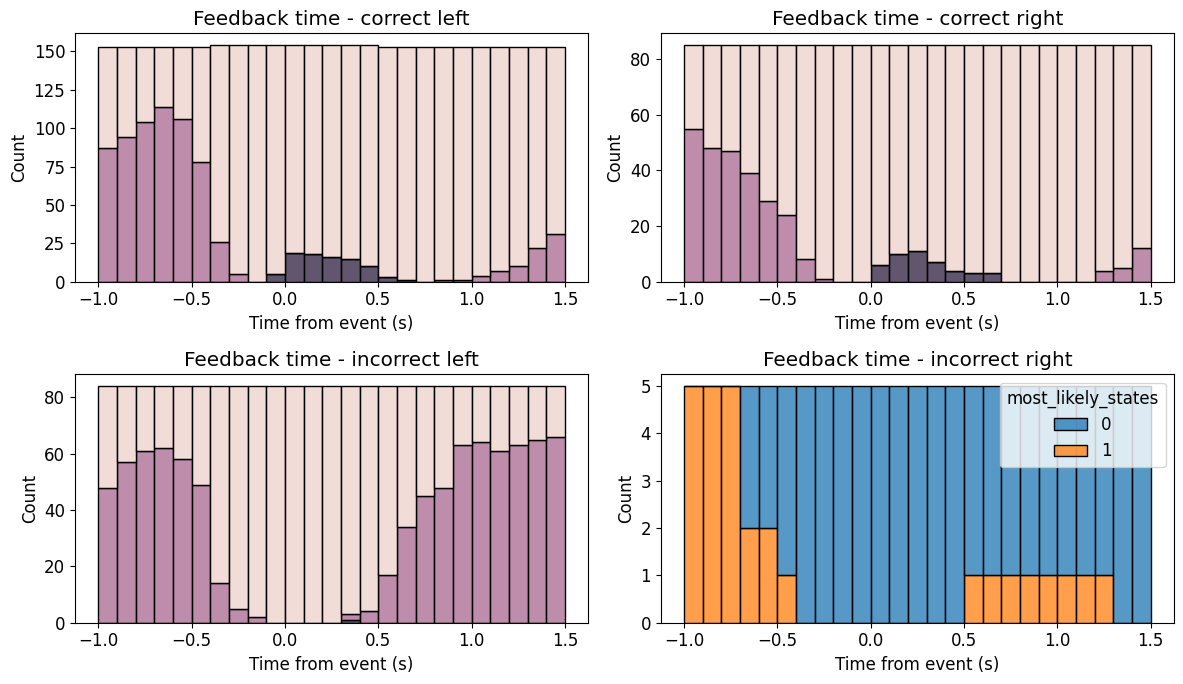

/tmp/ipykernel_17970/1860137500.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  reduced_design_matrix = design_matrix[:test_length*2].append(design_matrix[-test_length*2:])


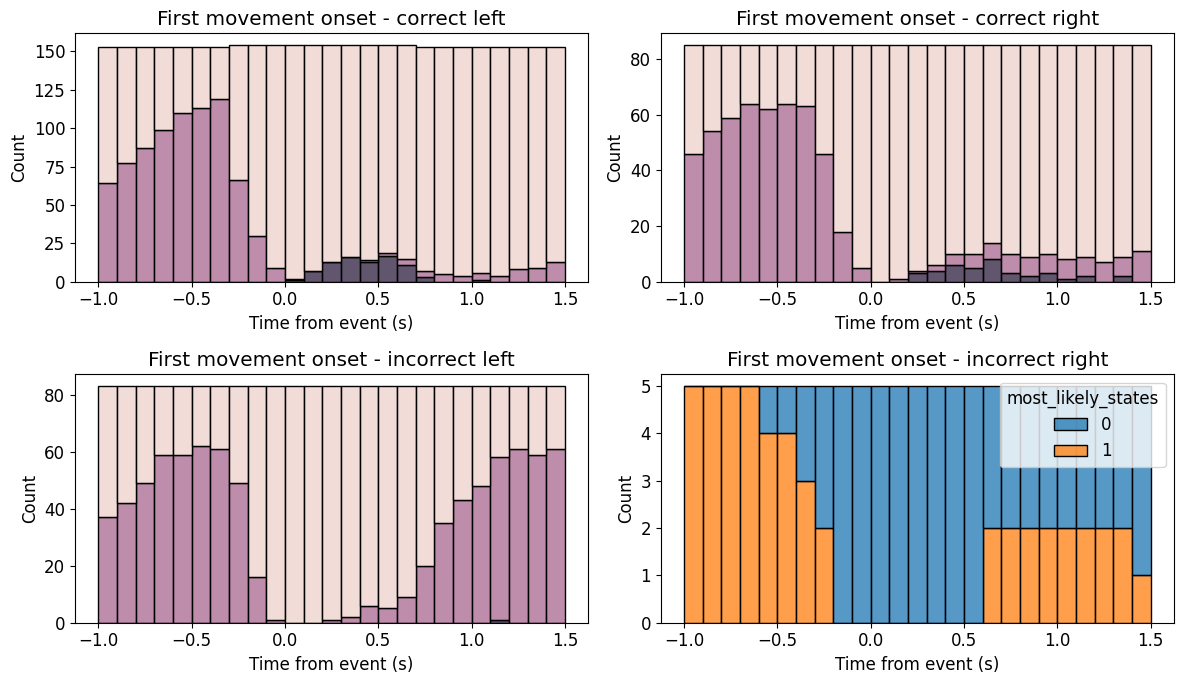

In [139]:
bin_size = 0.1
multiplier = 1/bin_size

init = -10
end = 15

event_type_list = ['goCueTrigger_times', 'feedback_times', 'firstMovement_times']
event_type_name = ['Go cue', 'Feedback time', 'First movement onset']

# TODO: turn into a function
for e, this_event in enumerate(event_type_list):
    
    # Initialize variables
    #reduced_design_matrix = design_matrix[:num_timesteps // num_train_batches * num_train_batches]
    #reduced_design_matrix = reduced_design_matrix[len(use_val)*use_fold:len(use_val)*(use_fold+1)]
    reduced_design_matrix = design_matrix[:test_length*2].append(design_matrix[-test_length*2:])
    reduced_design_matrix['most_likely_states'] = most_likely_states
    reduced_design_matrix['new_bin'] = reduced_design_matrix['Bin'] * 0
    reduced_design_matrix['correct'] = reduced_design_matrix['Bin'] * 0
    reduced_design_matrix['choice'] = reduced_design_matrix['Bin'] * 0
    
    #test_bin_init = 
    
    events = session_trials[this_event]
    feedback = session_trials['feedbackType']
    choice = session_trials['choice']
    
    events = session_trials[this_event]
    state_stack = np.zeros((len(events), end + init)) * np.nan
            
    for t, trial in enumerate(events[:-2]):
        event = events[t]
        
        # Check feedback
        if feedback[t] ==1:
            reduced_design_matrix.loc[(reduced_design_matrix['Bin']<= event*multiplier + end) &
                                        (reduced_design_matrix['Bin']> event*multiplier + init), 
                                        'correct'] = 1
        elif feedback[t] == 0:
            reduced_design_matrix.loc[(reduced_design_matrix['Bin']<= event*multiplier + end) &
                                        (reduced_design_matrix['Bin']> event*multiplier + init), 
                                        'correct'] = 0
        # Check choice
        if choice[t] ==1:
            reduced_design_matrix.loc[(reduced_design_matrix['Bin']<= event*multiplier + end) &
                                        (reduced_design_matrix['Bin']> event*multiplier + init), 
                                        'choice'] = 'right'
        elif choice[t] == -1:
            reduced_design_matrix.loc[(reduced_design_matrix['Bin']<= event*multiplier + end) &
                                        (reduced_design_matrix['Bin']> event*multiplier + init), 
                                        'choice'] = 'left'
        # Rename bins so that they are aligned on stimulus onset
        if event > 0:
            event_window = reduced_design_matrix.loc[(reduced_design_matrix['Bin']<= event*multiplier + end) & (reduced_design_matrix['Bin']> event*multiplier + init)]
            onset_bin = reduced_design_matrix.loc[reduced_design_matrix['Bin']>= event*multiplier, 'Bin']
            if (len(event_window)>0): # & len(onset_bin)>0:
                bin = list(onset_bin)[0]
                reduced_design_matrix.loc[(reduced_design_matrix['Bin']<= event*multiplier + end) &
                                        (reduced_design_matrix['Bin']> event*multiplier + init), 
                                        'new_bin'] = reduced_design_matrix.loc[(reduced_design_matrix['Bin']< event*multiplier + end) & 
                                        (reduced_design_matrix['Bin']>= event*multiplier + init), 'Bin'] - bin
            else:
                reduced_design_matrix.loc[(reduced_design_matrix['Bin']<= event*multiplier + end) & (reduced_design_matrix['Bin']> event*multiplier + init), 'new_bin'] = np.nan
        else:
            reduced_design_matrix.loc[(reduced_design_matrix['Bin']<= event*multiplier + end) & (reduced_design_matrix['Bin']> event*multiplier + init), 'new_bin'] = np.nan
            
    # PLOT
    fig, ax = plt.subplots(nrows=2, ncols=2, sharex=False, sharey=False, figsize=[12, 7])
    plt.rc('font', size=12)
    use_data = reduced_design_matrix.dropna()
    use_data['new_bin'] = use_data['new_bin'] * bin_size
    #use_data = use_data[:test_length*2]
    
    # Correct left
    a = sns.histplot(x='new_bin', hue='most_likely_states', data=use_data.loc[(use_data['correct']==1) 
                                                                              & (use_data['choice']=='left')], stat='count', 
                     multiple="stack", binwidth=bin_size, binrange=(bin_size*init, bin_size*end), legend=False, ax = ax[0, 0])
    # Correct right
    b = sns.histplot(x='new_bin', hue='most_likely_states', data=use_data.loc[(use_data['correct']==1) 
                                                                              & (use_data['choice']=='right')], stat='count', 
                     multiple="stack", binwidth=bin_size, binrange=(bin_size*init, bin_size*end), legend=False, ax = ax[0, 1])
    # Incorrect left
    c = sns.histplot(x='new_bin', hue='most_likely_states', data=use_data.loc[(use_data['correct']==0) 
                                                                              & (use_data['choice']=='left')], stat='count',
                     multiple="stack", binwidth=bin_size, binrange=(bin_size*init, bin_size*end), legend=False, ax = ax[1, 0])
    # Incorrect right
    d = sns.histplot(x='new_bin', hue='most_likely_states', data=use_data.loc[(use_data['correct']==0) 
                                                                              & (use_data['choice']=='right')], 
                     stat='count', multiple="stack", binwidth=bin_size, binrange=(bin_size*init, bin_size*end), ax = ax[1, 1])
    
    ax[0, 0].set_title(str(event_type_name[e] + ' - correct left'))
    ax[0, 0].set_xlabel(str('Time from event (s)'))

    ax[0, 1].set_title(str(event_type_name[e] + ' - correct right'))
    ax[0, 1].set_xlabel(str('Time from event (s)'))
    
    ax[1, 0].set_title(str(event_type_name[e] + ' - incorrect left'))
    ax[1, 0].set_xlabel(str('Time from event (s)'))
    
    ax[1, 1].set_title(str(event_type_name[e] + ' - incorrect right'))
    ax[1, 1].set_xlabel(str('Time from event (s)'))
    #sns.move_legend(d, "upper left", bbox_to_anchor=(1, 1))
    
    plt.tight_layout()
    plt.show()

### Plot for only the best fold

In [124]:
bin_size = 0.1
multiplier = 1/bin_size

init = -10
end = 15

event_type_list = ['goCueTrigger_times', 'feedback_times', 'firstMovement_times']
event_type_name = ['Go cue', 'Feedback time', 'First movement onset']

for e, this_event in enumerate(event_type_list):
    
    # Initialize variables
    #reduced_design_matrix = design_matrix[:num_timesteps // num_train_batches * num_train_batches]
    reduced_design_matrix = design_matrix[:test_length*2].append(design_matrix[-test_length*2:])
    reduced_design_matrix = reduced_design_matrix[len(use_val)*use_fold:len(use_val)*(use_fold+1)]
    reduced_design_matrix['most_likely_states'] = most_likely_states
    reduced_design_matrix['new_bin'] = reduced_design_matrix['Bin'] * 0
    reduced_design_matrix['correct'] = reduced_design_matrix['Bin'] * 0
    reduced_design_matrix['choice'] = reduced_design_matrix['Bin'] * 0
    
    events = session_trials[this_event]
    feedback = session_trials['feedbackType']
    choice = session_trials['choice']
    state_stack = np.zeros((len(events), end + init)) * np.nan
            
    for t, trial in enumerate(events[2:-2]):
        event = events[t]
        
        # Check feedback
        if feedback[t] ==1:
            reduced_design_matrix.loc[(reduced_design_matrix['Bin']<= event*multiplier + end) &
                                        (reduced_design_matrix['Bin']> event*multiplier + init), 
                                        'correct'] = 1
        elif feedback[t] == 0:
            reduced_design_matrix.loc[(reduced_design_matrix['Bin']<= event*multiplier + end) &
                                        (reduced_design_matrix['Bin']> event*multiplier + init), 
                                        'correct'] = 0
        # Check choice
        if choice[t] ==1:
            reduced_design_matrix.loc[(reduced_design_matrix['Bin']<= event*multiplier + end) &
                                        (reduced_design_matrix['Bin']> event*multiplier + init), 
                                        'choice'] = 'right'
        elif choice[t] == -1:
            reduced_design_matrix.loc[(reduced_design_matrix['Bin']<= event*multiplier + end) &
                                        (reduced_design_matrix['Bin']> event*multiplier + init), 
                                        'choice'] = 'left'
        # Rename bins so that they are aligned on stimulus onset
        if event > 0:
            event_window = reduced_design_matrix.loc[(reduced_design_matrix['Bin']<= event*multiplier + end) & (reduced_design_matrix['Bin']> event*multiplier + init)]
            onset_bin = reduced_design_matrix.loc[reduced_design_matrix['Bin']>= event*multiplier, 'Bin']
            if (len(event_window)>0 ):  # & len(onset_bin)>0
                bin = list(onset_bin)[0]
                reduced_design_matrix.loc[(reduced_design_matrix['Bin']<= event*multiplier + end) &
                                        (reduced_design_matrix['Bin']> event*multiplier + init), 
                                        'new_bin'] = reduced_design_matrix.loc[(reduced_design_matrix['Bin']< event*multiplier + end) & 
                                        (reduced_design_matrix['Bin']>= event*multiplier + init), 'Bin'] - bin
            else:
                reduced_design_matrix.loc[(reduced_design_matrix['Bin']<= event*multiplier + end) & (reduced_design_matrix['Bin']> event*multiplier + init), 'new_bin'] = np.nan
        else:
            reduced_design_matrix.loc[(reduced_design_matrix['Bin']<= event*multiplier + end) & (reduced_design_matrix['Bin']> event*multiplier + init), 'new_bin'] = np.nan

    # PLOT

    fig, ax = plt.subplots(nrows=2, ncols=2, sharex=False, sharey=False, figsize=[12, 7])
    plt.rc('font', size=12)
    use_data = reduced_design_matrix.dropna()
    use_data['new_bin'] = use_data['new_bin'] * bin_size
    
    # Correct left
    a = sns.histplot(x='new_bin', hue='most_likely_states', data=use_data.loc[(use_data['correct']==1) 
                                                                              & (use_data['choice']=='left')], stat='count', 
                     multiple="stack", binwidth=bin_size, binrange=(bin_size*init, bin_size*end), legend=False, ax = ax[0, 0])
    # Correct right
    b = sns.histplot(x='new_bin', hue='most_likely_states', data=use_data.loc[(use_data['correct']==1) 
                                                                              & (use_data['choice']=='right')], stat='count', 
                     multiple="stack", binwidth=bin_size, binrange=(bin_size*init, bin_size*end), legend=False, ax = ax[0, 1])
    # Incorrect left
    c = sns.histplot(x='new_bin', hue='most_likely_states', data=use_data.loc[(use_data['correct']==0) 
                                                                              & (use_data['choice']=='left')], stat='count',
                     multiple="stack", binwidth=bin_size, binrange=(bin_size*init, bin_size*end), legend=False, ax = ax[1, 0])
    # Incorrect right
    d = sns.histplot(x='new_bin', hue='most_likely_states', data=use_data.loc[(use_data['correct']==0) 
                                                                              & (use_data['choice']=='right')], 
                     stat='count', multiple="stack", binwidth=bin_size, binrange=(bin_size*init, bin_size*end), ax = ax[1, 1])
    
    ax[0, 0].set_title(str(event_type_name[e] + ' - correct left'))
    ax[0, 0].set_xlabel(str('Time from event (s)'))

    ax[0, 1].set_title(str(event_type_name[e] + ' - correct right'))
    ax[0, 1].set_xlabel(str('Time from event (s)'))
    
    ax[1, 0].set_title(str(event_type_name[e] + ' - incorrect left'))
    ax[1, 0].set_xlabel(str('Time from event (s)'))
    
    ax[1, 1].set_title(str(event_type_name[e] + ' - incorrect right'))
    ax[1, 1].set_xlabel(str('Time from event (s)'))
    #sns.move_legend(d, "upper left", bbox_to_anchor=(1, 1))
    
    plt.tight_layout()
    plt.show()

/tmp/ipykernel_62947/3318351614.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  reduced_design_matrix = design_matrix[:test_length*2].append(design_matrix[-test_length*2:])


IndexError: list index out of range

### Plot predictors overlayed with states

NameError: name 'complete_most_likely_states' is not defined

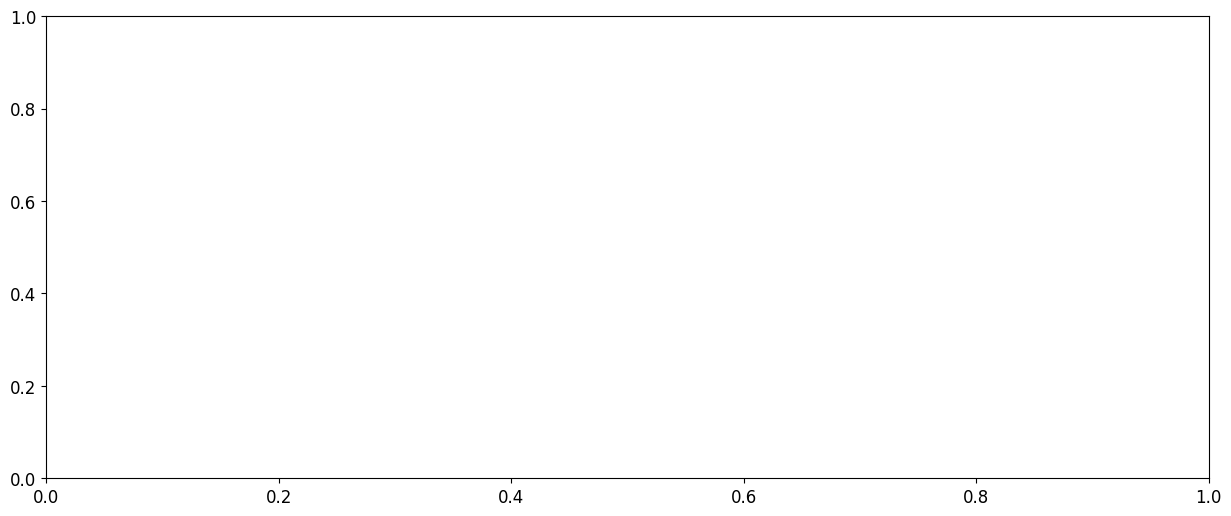

In [27]:
# Compute the most likely states
init = 1000 + len(use_val)*(use_fold)
end = 1200 + len(use_val)*(use_fold)

fig, axs = plt.subplots(1, 1, sharex=True, figsize=(15, 6))

#axs.imshow(
#    complete_most_likely_states[None,:], 
#    extent=(0, len(complete_most_likely_states), np.min(use_val) -.5, np.max(use_val) + .5),
#    aspect="auto",
#    cmap="Greys",
#    alpha=0.25) #extent=(0, end-init, np.min(test_set) -.5, np.max(test_set) + .5),

axs.imshow(
    complete_most_likely_states[None,:], 
    extent=(0, len(complete_most_likely_states), np.min(use_val) -.5, np.max(use_val) + .5),
    aspect="auto",
    cmap="Greys",
    alpha=0.25) #extent=(0, end-init, np.min(test_set) -.5, np.max(test_set) + .5),

axs.vlines(np.array(session_trials['goCueTrigger_times'] * 10), np.min(use_val) -.5, np.max(use_val) + .5, label='Stim On', color='Black')
axs.vlines(np.array(session_trials.loc[session_trials['feedbackType']==1, 'feedback_times'] * 10), np.min(use_val) -.5, np.max(use_val) + .5, label='Correct', color='Green')
axs.vlines(np.array(session_trials.loc[session_trials['feedbackType']==-1, 'feedback_times'] * 10), np.min(use_val) -.5, np.max(use_val) + .5, label='Incorrect', color='Red')
#axs.vlines(np.array(session_trials['firstMovement_times'] * 10), np.min(use_val) -.5, np.max(use_val) + .5, label='First movement', color='Blue')
axs.hlines(0, init, end, color='Gray', linewidth=.5)

# Plot original values
axs.plot(design_matrix['Bin'], design_matrix['whisker_me'], label='Whisker ME')
axs.plot(design_matrix['Bin'], design_matrix['nose_speed_X'], label='Nose speed')
axs.plot(design_matrix['Bin'], design_matrix['Gaussian_licks'], label='Licks')

axs.set_ylim(np.min(use_val) -.5, np.max(use_val) + .5)
axs.set_ylim(-7.5, 7.5)

axs.set_ylabel("emissions")
axs.set_xlabel("time (s)")
axs.set_xlim(init, end)
axs.set_xticks(np.arange(init, end+50, 50),np.arange(init/10, end/10+5, 5))

axs.set_title("inferred states")
plt.legend()
plt.tight_layout()

KeyError: 'whisker_me'

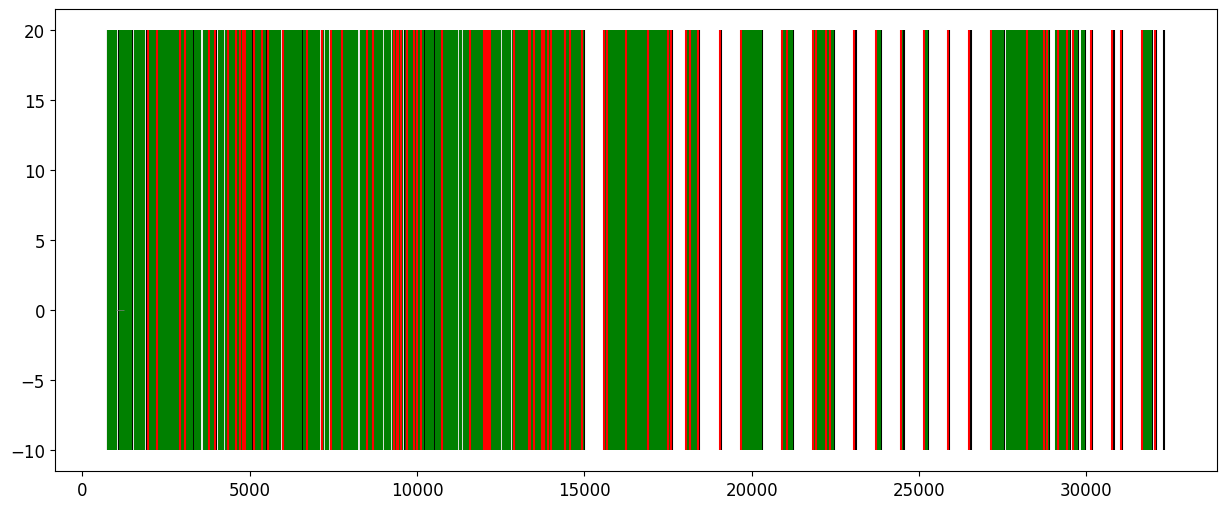

In [25]:
# Compute the most likely states
#init = 1000 + len(use_val)*(use_fold-1)
#end = 1500 + len(use_val)*(use_fold-1)

init = 1000
end = 1250

fig, axs = plt.subplots(1, 1, sharex=True, figsize=(15, 6))

axs.vlines(np.array(session_trials['goCueTrigger_times'] * 10), -10, 20, label='Stim On', color='Black')
axs.vlines(np.array(session_trials.loc[session_trials['feedbackType']==1, 'feedback_times'] * 10), -10, 20, label='Correct', color='Green')
axs.vlines(np.array(session_trials.loc[session_trials['feedbackType']==-1, 'feedback_times'] * 10), -10, 20, label='Incorrect', color='Red')
#axs.vlines(np.array(session_trials['firstMovement_times'] * 10), np.min(use_val) -.5, np.max(use_val) + .5, label='First movement', color='Blue')
axs.hlines(0, init, end, color='Gray', linewidth=.5)

# Plot original values
#axs.plot(design_matrix['Bin'], design_matrix['pupil_diameter'], label='Pupil diameter')
#axs.plot(design_matrix['Bin'], design_matrix['avg_wheel_vel'], label='Wheel velocity')
axs.plot(design_matrix['Bin'], design_matrix['whisker_me'], label='Whisker ME')
axs.plot(design_matrix['Bin'], design_matrix['nose_speed_X'], label='Nose speed')
axs.plot(design_matrix['Bin'], design_matrix['Gaussian_licks'], label='Licks')
#axs.plot(design_matrix['Bin'], design_matrix['r_paw_speed'], label='Right paw speed')
#axs.plot(design_matrix['Bin'], design_matrix['l_paw_speed'], label='Left paw speed')
#axs.plot(design_matrix['Bin'], design_matrix['pupil_speed'], label='Pupil speed')

       
#axs.set_ylim(np.min(use_val) -.5, np.max(use_val) + .5)
axs.set_ylim(-7.5, 20)

axs.set_ylabel("")
axs.set_xlabel("time (s)")
axs.set_xlim(init, end)
axs.set_xticks(np.arange(init, end+50, 50),np.arange(init/10, end/10+5, 5))

axs.set_title("")
plt.legend()
plt.tight_layout()


(14682, 2)


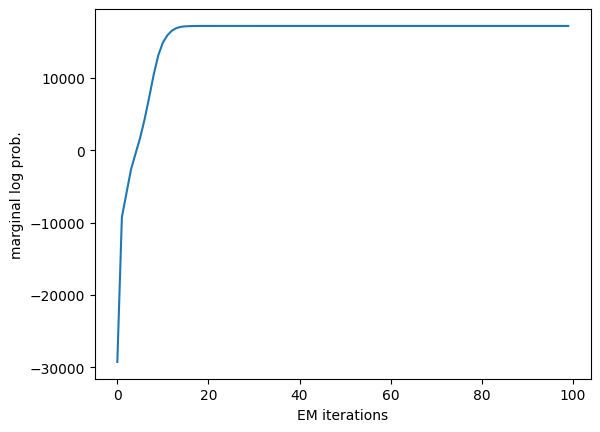

In [98]:
# Make a Gaussian HMM and sample data from it
hmm = GaussianHMM(num_states, emission_dim, transition_matrix_concentration=1)
#true_params, _ = hmm.initialize(key1)
#true_states, emissions = hmm.sample(true_params, key2, num_timesteps)

# Make a new Gaussian HMM and fit it with EM
params_init, props = hmm.initialize(key3, method="kmeans", emissions=standardized_matrix)
params, lls = hmm.fit_em(params_init, props, standardized_matrix, num_iters=100)

# Plot the marginal log probs across EM iterations
plt.plot(lls)
plt.xlabel("EM iterations")
plt.ylabel("marginal log prob.")

# Use fitted model for posterior inference
post = hmm.smoother(params, standardized_matrix)
print(post.smoothed_probs.shape) # (1000, 3)